In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hammadjavaid/6992-labeled-meme-images-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/6992-labeled-meme-images-dataset


In [2]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
import re
from PIL import Image
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Imports loaded, device:", device)

Imports loaded, device: cuda


In [3]:
class ImprovedPolicyNetwork(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.hidden_dim = hidden_dim
        
    def forward(self, input_ids, hidden=None):
        """
        Args:
            input_ids: [batch, seq]
            hidden: LSTM hidden state (optional)
        Returns:
            logits: [batch, seq, vocab]
            hidden: Updated LSTM hidden state
        """
        batch_size = input_ids.size(0)
        embeds = self.embedding(input_ids)
        lstm_out, hidden = self.lstm(embeds, hidden)
        logits = self.fc(lstm_out)  # [batch, seq, vocab]
        return logits, hidden

class ImprovedValueNetwork(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, input_ids, hidden=None):
        embeds = self.embedding(input_ids)
        lstm_out, hidden = self.lstm(embeds, hidden)
        value = self.fc(lstm_out[:, -1, :])
        return value, hidden

print("Model architecture defined!")

Model architecture defined!


In [4]:
from collections import Counter
import nltk

def extract_contextual_phrases(text):
    text = str(text).lower().strip()
    if not text:
        return [], []
    try:
        sentences = nltk.sent_tokenize(text)
    except:
        sentences = [text]
    all_phrases = []
    key_words = []
    for sentence in sentences:
        try:
            tokens = nltk.word_tokenize(sentence)
            pos_tags = nltk.pos_tag(tokens)
            nouns = [word.upper() for word, tag in pos_tags if tag.startswith('N') and len(word) > 2]
            verbs = [word.upper() for word, tag in pos_tags if tag.startswith('V') and len(word) > 2]
            adjs = [word.upper() for word, tag in pos_tags if tag.startswith('J') and len(word) > 2]
            key_words.extend(nouns + verbs + adjs)
            i = 0
            while i < len(pos_tags) - 1:
                if (pos_tags[i][1].startswith('J') and pos_tags[i+1][1].startswith('N')) or \
                   (pos_tags[i][1] in ('DT', 'PRP$') and pos_tags[i+1][1].startswith('N')):
                    phrase = pos_tags[i][0] + " " + pos_tags[i+1][0]
                    j = i + 2
                    while j < len(pos_tags) and pos_tags[j][1].startswith(('J', 'N')):
                        phrase += " " + pos_tags[j][0]
                        j += 1
                    all_phrases.append(phrase.upper())
                    i = j
                else:
                    i += 1
            for i in range(len(pos_tags) - 2):
                if pos_tags[i][1].startswith(('N', 'PRP')) and \
                   pos_tags[i+1][1].startswith('V') and \
                   i+2 < len(pos_tags) and pos_tags[i+2][1].startswith(('N', 'PRP', 'J')):
                    phrase = pos_tags[i][0] + " " + pos_tags[i+1][0] + " " + pos_tags[i+2][0]
                    all_phrases.append(phrase.upper())
        except:
            words = sentence.split()
            if words:
                key_words.extend([w.upper() for w in words if len(w) > 2])
                if len(words) >= 3:
                    for i in range(len(words) - 2):
                        all_phrases.append(" ".join(words[i:i+3]).upper())
    if not all_phrases and key_words:
        all_phrases = [w for w in key_words]
    key_words = list(dict.fromkeys(key_words))
    all_phrases = list(dict.fromkeys(all_phrases))
    return all_phrases, key_words

def generate_contextual_meme_template(original_text, context_phrases, starter_templates):
    contextual_phrases, key_words = extract_contextual_phrases(original_text)
    if contextual_phrases and len(contextual_phrases) >= 1 and random.random() < 0.7:
        phrase = random.choice(contextual_phrases[:3] if len(contextual_phrases) > 3 else contextual_phrases)
        phrase_words = phrase.split()
        if len(phrase_words) >= 3:
            templates = [
                f"WHEN {phrase} ",
                f"TFW {phrase} ",
                f"ME WHEN {phrase} ",
                f"POV: {phrase} ",
                f"{phrase} BE LIKE: ",
                f"NOBODY:\nME: {phrase} "
            ]
        elif len(phrase_words) == 2:
            templates = [
                f"WHEN {phrase} HAPPENS ",
                f"{phrase_words[0]} {phrase_words[1]} ENERGY ",
                f"MY {phrase} WHEN ",
                f"THAT {phrase} MOMENT WHEN ",
                f"{phrase}.EXE HAS STOPPED WORKING "
            ]
        else:
            word = phrase_words[0]
            templates = [
                f"WHEN THE {word} ",
                f"{word}.EXE HAS CRASHED ",
                f"NOBODY ASKED ABOUT YOUR {word} ",
                f"THAT {word} FEELING WHEN ",
                f"{word} INTENSIFIES "
            ]
        template = random.choice(templates)
    elif key_words and random.random() < 0.6:
        word = random.choice(key_words[:3] if len(key_words) > 3 else key_words)
        templates = [
            f"WHEN {word} ",
            f"TFW {word} ",
            f"MY {word} BE LIKE: ",
            f"{word}.EXE HAS STOPPED WORKING ",
            f"NOBODY CARES ABOUT YOUR {word} ",
            f"INTERNAL {word} SCREAMING "
        ]
        template = random.choice(templates)
    else:
        template = random.choice(starter_templates)
    return template, contextual_phrases, key_words

def postprocess_caption(caption):
    words = caption.split()
    cleaned = []
    prev_word = None
    for word in words:
        if word != prev_word:
            cleaned.append(word)
            prev_word = word
    caption = " ".join(cleaned)
    if "YOU YOU" in caption:
        caption = caption.replace("YOU YOU", "YOU")
    caption = re.sub(r'\b(AND|THE|A|OF|TO|FOR|IN|ON|BY)\s*$', '', caption, flags=re.IGNORECASE)
    caption = re.sub(r'\s+([.,!?:;])', r'\1', caption)
    if len(caption) >= 5 and caption[-1] not in ".!?":
        if "?" in caption:
            caption += "?"
        elif any(word in caption.upper() for word in ["FAIL", "BAD", "TERRIBLE", "NO", "CAN'T"]):
            caption += "!"
        else:
            caption += "."
    return caption.strip()

def predict_humor(text):
    words = text.split()
    humor_score = 0.5
    modern_slang = [
        "YEET", "OOF", "BRUH", "SUS", "BASED", "NO CAP", "SHEESH", "SLAY", "VIBE CHECK", "SIMP", "STAN",
        "CHAD", "KAREN", "BOOMER", "ZOOMER", "SIGMA", "ALPHA", "MATERIAL GIRL", "UNDERSTOOD THE ASSIGNMENT",
        "MAIN CHARACTER", "VILLAIN ERA", "CORE", "CODED", "UNSERIOUS", "MOTHER", "FATHER", "MOTHERING",
        "FATHERING", "BANGER", "SLEPT ON", "RENT FREE", "LIVES IN MY HEAD", "GASLIGHT", "GATEKEEP",
        "GIRLBOSS", "CAUGHT IN 4K", "RIZZ", "NO RIZZ", "UNHINGED", "LIVING MY BEST LIFE", "GIVING",
        "SERVED", "ATE", "LEFT NO CRUMBS", "404", "HOTFIX", "SENDHELP"
    ]
    if any(text.startswith(prefix) for prefix in ["WHEN ", "TFW ", "POV: ", "NO ONE:", "ME WHEN "]):
        humor_score += 0.2
    if "#" in text:
        humor_score += 0.1
    if any(word in modern_slang for word in words):
        humor_score += 0.2
    if "BUT" in words or "WHEN" in words:
        humor_score += 0.2
    if "404" in words or "HOTFIX" in words or ".EXE" in text:
        humor_score += 0.2
    if len(words) < 3:
        humor_score -= 0.2
    return min(1.2, max(0.1, humor_score))

def filter_and_cluster_data(humor_df, min_humor_score=0.5, num_clusters=10):
    humor_scores = [predict_humor(text) for text in humor_df['text']]
    humor_df['humor_score'] = humor_scores
    filtered_df = humor_df[humor_df['humor_score'] >= min_humor_score]
    texts = filtered_df['text'].tolist()
    if len(texts) > 100:
        vectorizer = TfidfVectorizer(max_features=1000)
        X = vectorizer.fit_transform(texts)
        kmeans = KMeans(n_clusters=min(num_clusters, len(texts) // 10), random_state=42)
        clusters = kmeans.fit_predict(X)
        filtered_df['cluster'] = clusters
    else:
        filtered_df['cluster'] = 0
    return filtered_df

def build_enhanced_vocabulary(train_df, humor_df):
    modern_meme_phrases = [
        "WHEN YOU", "TFW", "POV:", "BRUH MOMENT", "ERROR 404", "BIG OOF", "SMALL BRAIN", "YEET MODE",
        "INSTANT REGRET", "IT'S GIVING", "MAIN CHARACTER", "VILLAIN ERA", "CHRONICALLY ONLINE", "NO THOUGHTS",
        "HEAD EMPTY", "JUST VIBING", "NO CONTEXT", "ZERO CHILL", "TOUCH GRASS", "BROKE IRL", "IN MY FEELS",
        "NERF THIS", "DEAD INSIDE", "FINAL FORM", "WIFI LOST", "SUS ALERT", "RATIO", "LITERALLY WHO",
        "BIG SAD", "NPC ENERGY", "LOFI VIBES", "TRASH TIER", "GIGACHAD", "THIS AIN'T IT", "404 BRAIN",
        "SPEEDRUN LIFE", "NPC DIALOGUE", "LOW EFFORT", "NOBODY ASKED", "MY LAST BRAINCELL", "ERROR LOADING",
        "SYSTEM FAILURE", "BRAIN.EXE STOPPED", "INTERNAL SCREAMING", "VISIBLE CONFUSION", "TASK FAILED",
        "SUFFERING FROM SUCCESS", "MISSION FAILED", "CONNECTION LOST", "SIGNAL WEAK", "SCREAMING INTERNALLY",
        "NOT ME THINKING", "LIVING MY BEST LIFE", "UNHINGED BEHAVIOR", "EMOTIONAL DAMAGE", "CLOWN BEHAVIOR",
        "ERROR 404 INPUT #SENDHELP", "INPUT.EXE CRASHED", "HOTFIX MY INPUT", "COFFEE CRASH", "ZOMBIE MODE",
        "ME WHEN INPUT", "TFW INPUT HAPPENS", "INPUT INTENSIFIES"
    ]
    context_phrases = [
        "ME AT WORK", "ME AT 3 AM", "MY BRAIN", "MY BANK ACCOUNT", "MY LAST BRAINCELL", "EVERYONE ELSE",
        "MY FRIENDS", "SOCIETY", "MY PROFESSOR", "MY BOSS", "MY PARENTS", "THE INTERNET", "GAMERS",
        "INTROVERTS", "EXTROVERTS", "MY RESUME", "MY SEARCH HISTORY", "MY SPOTIFY", "MY CAMERA ROLL"
    ]
    emotion_states = [
        "PAIN", "VOID", "CHAOS", "CRISIS", "EMPTY", "LOADING", "BROKEN", "FAILED", "CURSED", "BUFFERING",
        "CORRUPTED", "CRASHED", "GLITCHED", "REBOOT", "FROZEN", "LAGGING", "DELETED", "EXPLODED", "VANISHED",
        "SCREAMING", "VIBING", "FOCUSING", "SUCCEEDING", "WINNING", "GAMING", "GRINDING", "LEVELING",
        "ASCENDING", "ENLIGHTENED", "THRIVING", "BLESSED"
    ]
    modern_slang = [
        "YEET", "OOF", "BRUH", "SUS", "BASED", "NO CAP", "SHEESH", "SLAY", "VIBE CHECK", "SIMP", "STAN",
        "CHAD", "KAREN", "BOOMER", "ZOOMER", "SIGMA", "ALPHA", "MATERIAL GIRL", "UNDERSTOOD THE ASSIGNMENT",
        "MAIN CHARACTER", "VILLAIN ERA", "CORE", "CODED", "UNSERIOUS", "MOTHER", "FATHER", "MOTHERING",
        "FATHERING", "BANGER", "SLEPT ON", "RENT FREE", "LIVES IN MY HEAD", "GASLIGHT", "GATEKEEP",
        "GIRLBOSS", "CAUGHT IN 4K", "RIZZ", "NO RIZZ", "UNHINGED", "LIVING MY BEST LIFE", "GIVING",
        "SERVED", "ATE", "LEFT NO CRUMBS", "404", "HOTFIX", "SENDHELP"
    ]
    vocab = set()
    word_counts = Counter()
    for caption in train_df['text_corrected'].tolist() + humor_df['text'].tolist():
        words = str(caption).upper().split()
        tagged = pos_tag(words)
        word_counts.update(w for w, tag in tagged if tag.startswith(('N', 'V', 'J')) and len(w) > 2)
    frequent_words = [w for w, c in word_counts.items() if c > 5]
    for caption in train_df['text_corrected'].tolist() + humor_df['text'].tolist():
        words = str(caption).upper().split()
        cleaned_words = [w for w in words if not re.match(r'^(https?://|www\.|\.com$|\.net$|\.xyz$)', w.lower()) and len(w) > 2]
        vocab.update(w for w in cleaned_words if w in frequent_words)
    for phrase in modern_meme_phrases + context_phrases:
        vocab.update(phrase.split())
    vocab.update(emotion_states + modern_slang + ["<START>", "<END>", "<UNK>"])
    return list(vocab), modern_slang, modern_meme_phrases, context_phrases, emotion_states

# Load data
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
labels_df = pd.read_csv('/kaggle/input/6992-labeled-meme-images-dataset/labels.csv')
train_df = labels_df.sample(frac=0.8, random_state=SEED)
test_df = labels_df.drop(train_df.index)
train_df['text_corrected'] = train_df['text_corrected'].fillna("")
humor_df = pd.read_csv("/kaggle/input/dataset/humor_dataset.csv")
humor_df['text'] = humor_df['text'].fillna("")
filtered_humor_df = filter_and_cluster_data(humor_df)
vocab, modern_slang, starter_templates, context_phrases, emotion_states = build_enhanced_vocabulary(train_df, filtered_humor_df)
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for i, word in enumerate(vocab)}
vocab_size = len(vocab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Data loaded: {len(train_df)} train, {len(test_df)} test, {len(filtered_humor_df)} humor samples")
print(f"Vocab size: {vocab_size}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Data loaded: 5594 train, 1398 test, 600 humor samples
Vocab size: 1587


In [5]:
def improved_contextual_reward(caption, original=None, sentiment=None):
    words = caption.split()
    unique_words = set(words)
    humor_score = predict_humor(caption) * 1.5
    meme_score = min(1.0, 0.2 * (caption == caption.upper()) + 0.2 * caption.count("#"))
    coherence_score = 0.0
    if len(words) >= 3:
        try:
            pos_tags = nltk.pos_tag(words)
            has_noun = any(tag.startswith('N') for _, tag in pos_tags)
            has_verb = any(tag.startswith('V') for _, tag in pos_tags)
            if has_noun and has_verb:
                coherence_score += 0.5
        except:
            pass
    repetition_count = sum(words.count(w) > 1 for w in unique_words)
    repetition_penalty = min(-2.0, -0.5 * repetition_count)
    format_bonus = 0.0
    if any(caption.startswith(prefix) for prefix in ["WHEN ", "TFW ", "POV: ", "ME WHEN "]):
        format_bonus += 0.5
    context_bonus = 0.0
    if original:
        contextual_phrases, key_words = extract_contextual_phrases(original)
        if key_words:
            caption_words = set(caption.upper().split())
            keyword_overlap = sum(1 for word in key_words if word in caption_words)
            context_bonus = min(3.0, 1.0 + keyword_overlap * 0.7)
            if keyword_overlap == 0:
                context_bonus = -2.0
            original_text = str(original).upper()
            thematic_markers = ["FAIL", "WIN", "SUCCESS", "SAD", "HAPPY", "ANGRY", "BAD", "GOOD"]
            for marker in thematic_markers:
                if (marker in original_text and marker in caption) or \
                   (marker not in original_text and marker not in caption):
                    context_bonus += 0.3
                    break
            if contextual_phrases:
                for phrase in contextual_phrases:
                    phrase_words = phrase.split()
                    if len(phrase_words) >= 2:
                        phrase_overlap = sum(1 for word in phrase_words if word in caption_words)
                        if phrase_overlap >= len(phrase_words) * 0.7:
                            context_bonus += 0.8
                            break
                        elif phrase_overlap >= 2:
                            context_bonus += 0.4
                            break
    length = len(words)
    length_bonus = 0.8 if 5 <= length <= 10 else max(0, 0.8 - 0.15 * abs(length - 7))
    if length < 3:
        length_bonus = -1.0
    total_reward = (
        humor_score * 0.8 +
        meme_score * 0.5 +
        repetition_penalty +
        coherence_score * 0.5 +
        format_bonus * 0.4 +
        length_bonus * 0.5 +
        context_bonus * 3.0
    )
    return total_reward

print("Reward function ready!")

Reward function ready!


In [6]:
def pre_train_with_templates(model, train_data, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()
    print("Starting pre-training...")
    for epoch in range(epochs):
        total_loss = 0
        for caption in train_data['text_corrected'].tolist():
            caption = str(caption).upper()
            template, _, _ = generate_contextual_meme_template(caption, context_phrases, starter_templates)
            tokens = ["<START>"] + template.split() + caption.split()[:5] + ["<END>"]
            input_ids = torch.tensor([word_to_idx.get(w, word_to_idx["<UNK>"]) for w in tokens[:-1]], device=device).unsqueeze(0)
            targets = torch.tensor([word_to_idx.get(w, word_to_idx["<UNK>"]) for w in tokens[1:]], device=device).unsqueeze(0)
            optimizer.zero_grad()
            logits, _ = model(input_ids)  # [batch=1, seq, vocab]
            logits = logits.view(-1, vocab_size)  # [seq, vocab]
            targets = targets.view(-1)  # [seq]
            loss = criterion(logits, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
        print(f"Pre-training Epoch {epoch}, Avg Loss: {total_loss / len(train_data):.2f}")

policy_net = ImprovedPolicyNetwork(vocab_size).to(device)
pre_train_with_templates(policy_net, train_df)
torch.save(policy_net.state_dict(), "policy_net_pre_v7.pt")
print("Pre-training complete!")

Starting pre-training...
Pre-training Epoch 0, Avg Loss: 3.76
Pre-training Epoch 1, Avg Loss: 3.25
Pre-training Epoch 2, Avg Loss: 3.03
Pre-training Epoch 3, Avg Loss: 2.84
Pre-training Epoch 4, Avg Loss: 2.67
Pre-training Epoch 5, Avg Loss: 2.52
Pre-training Epoch 6, Avg Loss: 2.41
Pre-training Epoch 7, Avg Loss: 2.33
Pre-training Epoch 8, Avg Loss: 2.26
Pre-training Epoch 9, Avg Loss: 2.20
Pre-training complete!


In [10]:
def adaptive_temperature(tokens, base_length):
    return 0.7 + (1.4 - 0.7) * min(1.0, len(tokens) / base_length)

def train_with_contextual_curriculum(policy_net, value_net, train_data):
    policy_optimizer = optim.Adam(policy_net.parameters(), lr=0.0001)
    value_optimizer = optim.Adam(value_net.parameters(), lr=0.0001)
    curriculum_levels = [
        {"max_len": 4, "entropy_bonus": 0.02, "epochs": 200, "episodes": 50, "report_every": 50},
        {"max_len": 6, "entropy_bonus": 0.02, "epochs": 400, "episodes": 50, "report_every": 50},
        {"max_len": 8, "entropy_bonus": 0.015, "epochs": 400, "episodes": 50, "report_every": 50}
    ]
    print("Training with contextual curriculum...")
    for level in curriculum_levels:
        print(f"\nCurriculum level: {level['max_len']} words, entropy: {level['entropy_bonus']}")
        for epoch in range(level["epochs"]):
            total_loss = 0
            episodes = level["episodes"]
            if 'cluster' in train_data.columns:
                sampled_data = []
                for cluster_id in train_data['cluster'].unique():
                    cluster_samples = train_data[train_data['cluster'] == cluster_id]
                    n_samples = max(1, episodes // len(train_data['cluster'].unique()))
                    sampled_indices = np.random.choice(cluster_samples.index, size=min(n_samples, len(cluster_samples)), replace=False)
                    sampled_data.extend(train_data.loc[sampled_indices]['text'].tolist())
            else:
                sampled_data = np.random.choice(train_data['text_corrected'].tolist(), size=episodes, replace=True)
            for ep, caption in enumerate(sampled_data):
                original_text = str(caption)
                contextual_template, contextual_phrases, key_words = generate_contextual_meme_template(
                    original_text, context_phrases, starter_templates)
                tokens = ["<START>"] + contextual_template.split()
                if key_words and random.random() > 0.3:
                    available_keywords = [w for w in key_words if w not in tokens]
                    if available_keywords:
                        tokens.append(random.choice(available_keywords))
                input_ids = torch.tensor([word_to_idx.get(w, word_to_idx["<UNK>"]) for w in tokens], device=device).unsqueeze(0)
                log_probs, values, rewards, entropies = [], [], [], []
                hidden_policy, hidden_value = None, None
                used_context = set(w.upper() for w in tokens[1:])
                for t in range(level["max_len"]):
                    logits, hidden_policy = policy_net(input_ids, hidden_policy)
                    logits = logits[:, -1, :]  # [batch, vocab]
                    value, hidden_value = value_net(input_ids, hidden_value)
                    probs = torch.softmax(logits, dim=-1)
                    if t >= 2 and key_words and random.random() > 0.4:
                        probs = probs.clone()
                        for word in key_words:
                            if word in word_to_idx and word not in used_context:
                                probs[0, word_to_idx[word]] *= 2.0
                    action = torch.multinomial(probs, 1).item()
                    log_prob = torch.log(probs[0, action] + 1e-10)
                    entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
                    next_word = idx_to_word[action]
                    tokens.append(next_word)
                    used_context.add(next_word.upper())
                    input_ids = torch.tensor([[action]], device=device)
                    caption_so_far = " ".join([w for w in tokens[1:] if w != "<START>"])
                    reward = 0
                    if next_word == "<END>" or t == level["max_len"] - 1:
                        sentiment = train_df[train_df['text_corrected'] == caption]['overall_sentiment'].iloc[0] if caption in train_df['text_corrected'].values else None
                        caption_so_far = postprocess_caption(caption_so_far)
                        reward = improved_contextual_reward(caption_so_far, original_text, sentiment)
                    log_probs.append(log_prob)
                    values.append(value)
                    rewards.append(reward)
                    entropies.append(entropy)
                    if next_word == "<END>" or t == level["max_len"] - 1:
                        break
                returns = []
                R = 0
                for r in rewards[::-1]:
                    R = r + 0.99 * R
                    returns.insert(0, R)
                returns = torch.tensor(returns, device=device)
                log_probs = torch.stack(log_probs)
                values = torch.cat(values)
                entropies = torch.stack(entropies)
                advantage = returns - values
                actor_loss = -log_probs * advantage.detach()
                critic_loss = advantage.pow(2)
                entropy_bonus = -level["entropy_bonus"] * entropies
                loss = actor_loss.mean() + 0.5 * critic_loss.mean() + entropy_bonus.mean()
                total_loss += loss.item()
                policy_optimizer.zero_grad()
                value_optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                torch.nn.utils.clip_grad_norm_(value_net.parameters(), 1.0)
                policy_optimizer.step()
                value_optimizer.step()
            if epoch % level["report_every"] == 0:
                print(f"Epoch {epoch}, Avg Loss: {total_loss / episodes:.2f}")
                if epoch % (level["report_every"] * 5) == 0:
                    example_text = random.choice(train_data['text_corrected'].tolist())
                    caption, reward = generate_highly_contextual_caption(
                        example_text, policy_net, word_to_idx, idx_to_word,
                        modern_slang, starter_templates, context_phrases)
                    caption = postprocess_caption(caption)
                    print(f"Example: '{example_text}' -> '{caption}' (Reward: {reward:.2f})")

value_net = ImprovedValueNetwork(vocab_size).to(device)
train_data = pd.concat([train_df[['text_corrected']], filtered_humor_df[['text', 'cluster']]], axis=0, ignore_index=True)
train_with_contextual_curriculum(policy_net, value_net, train_data)
torch.save(policy_net.state_dict(), "policy_net_a2c_v7.pt")
torch.save(value_net.state_dict(), "value_net_a2c_v7.pt")
print("A2C training complete!")

Training with contextual curriculum...

Curriculum level: 4 words, entropy: 0.02
Epoch 0, Avg Loss: 44.05
Example: 'Cole Sprouse looks like young Leonardo DiCaprio ** WOW' -> 'NOBODY: ME: DICAPRIO ** WOW SPROUSE LOOKS LIKE BRIAN LEONARDO <UNK> YOUNG!' (Reward: 11.00)
Epoch 50, Avg Loss: 2.57
Epoch 100, Avg Loss: 0.82
Epoch 150, Avg Loss: 0.78

Curriculum level: 6 words, entropy: 0.02
Epoch 0, Avg Loss: 2.23
Example: 'the shower feeling nice and clean* hitler:' -> 'NOBODY CARES ABOUT YOUR HITLER FEELING CLEAN* PROMISED ME NICE!' (Reward: 11.40)
Epoch 50, Avg Loss: 0.80
Epoch 100, Avg Loss: 2.27
Epoch 150, Avg Loss: 0.64
Epoch 200, Avg Loss: 0.35
Epoch 250, Avg Loss: 0.49
Example: 'AT A SLEEPOVER IN A FRIEND'S HOUSE FIRST ONE TO WAKE UP made on imagur' -> 'MY A FRIEND WHEN MADE SLEEPOVER WE'RE ONLY HOUSE.' (Reward: 11.64)
Epoch 300, Avg Loss: -0.19
Epoch 350, Avg Loss: 0.94

Curriculum level: 8 words, entropy: 0.015
Epoch 0, Avg Loss: 0.13
Example: 'BITCH  PLEASE.... I'M HARRY SPECTER qu

In [9]:
def adaptive_temperature(tokens, base_length):
    return 0.7 + (1.4 - 0.7) * min(1.0, len(tokens) / base_length)

def generate_highly_contextual_caption(text, policy_net, word_to_idx, idx_to_word, 
                                     modern_slang, starter_templates, context_phrases, 
                                     max_length=12, min_length=4):
    contextual_template, contextual_phrases, key_words = generate_contextual_meme_template(
        text, context_phrases, starter_templates)
    tokens = ["<START>"] + contextual_template.split()
    if key_words:
        template_words = set(w.upper() for w in contextual_template.split())
        available_keywords = [w for w in key_words if w not in template_words]
        if available_keywords and len(tokens) < max_length - 3:
            num_words = min(2, len(available_keywords), max_length - len(tokens) - 2)
            for _ in range(num_words):
                if available_keywords:
                    word = random.choice(available_keywords)
                    tokens.append(word)
                    available_keywords.remove(word)
    input_ids = torch.tensor([word_to_idx.get(w, word_to_idx["<UNK>"]) 
                             for w in tokens], device=device).unsqueeze(0)
    hidden = None
    used_context = set(w.upper() for w in tokens[1:])
    has_hashtag = False
    has_slang = False
    mandatory_keywords = []
    remaining_keywords = [w for w in key_words if w not in used_context]
    if remaining_keywords:
        num_mandatory = min(2, len(remaining_keywords))
        mandatory_keywords = random.sample(remaining_keywords, num_mandatory)
    for i in range(max_length):
        logits, hidden = policy_net(input_ids, hidden)
        logits = logits[:, -1, :] / adaptive_temperature(tokens, len(contextual_template.split()) + 1)  # [batch, vocab]
        probs = torch.softmax(logits, dim=-1)
        top_k = min(50, probs.size(-1))
        top_k_probs, top_k_indices = torch.topk(probs, top_k, dim=-1)
        probs = torch.zeros_like(probs).scatter_(-1, top_k_indices, top_k_probs)
        probs = probs / probs.sum(dim=-1, keepdim=True)
        if mandatory_keywords and (i == 2 or i == 4 or (i >= 5 and random.random() < 0.3)):
            word = mandatory_keywords.pop(0)
            if word in word_to_idx:
                action = word_to_idx[word]
                next_word = word
            else:
                action = torch.multinomial(probs, 1).item()
                next_word = idx_to_word[action]
                if mandatory_keywords:
                    mandatory_keywords.append(word)
                elif word not in used_context:
                    mandatory_keywords.append(word)
        else:
            if key_words and i >= 2:
                probs = probs.clone()
                for word in key_words:
                    if word in word_to_idx and word not in used_context:
                        probs[0, word_to_idx[word]] *= 2.0
            if not has_slang and i >= 3 and random.random() > 0.5 and len(tokens) < max_length - 3:
                for slang in modern_slang:
                    if slang in word_to_idx:
                        probs[0, word_to_idx[slang]] *= 1.5
                has_slang = True
            action = torch.multinomial(probs, 1).item()
            next_word = idx_to_word[action]
        tokens.append(next_word)
        used_context.add(next_word.upper())
        input_ids = torch.tensor([[action]], device=device)
        if next_word.startswith("#") and not has_hashtag and i >= 3:
            has_hashtag = True
        elif next_word.startswith("#") and has_hashtag:
            continue
        if next_word == "<END>" or (i >= min_length and random.random() < 0.2):
            break
    caption = " ".join([w for w in tokens[1:] if w != "<END>"])
    caption = postprocess_caption(caption)
    sentiment = test_df[test_df['text_corrected'] == text]['overall_sentiment'].iloc[0] if text in test_df['text_corrected'].values else None
    reward = improved_contextual_reward(caption, text, sentiment)
    return caption, reward

print("Generation ready!")

Generation ready!



Generating sample captions with enhanced context preservation...

Sample 1:
Original: 10 Year Challenge - Sweet Dee Edition
Generated: DEE EDITION.EXE HAS STOPPED WORKING YEAR SWEET WORLD HAPPENS.
Humor: 0.70, Coherence: 0.5, Format: 0.7
Context Overlap: 0.67, Key Content Preserved: 0.80
Image path: /kaggle/input/6992-labeled-meme-images-dataset/images/images/image_4.png


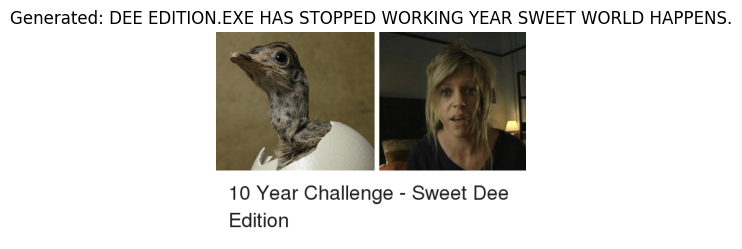


Sample 2:
Original: 10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious 10 Year Challenge Memes | What is #10 Year Challenge?
Generated: NO FILTER.EXE HAS STOPPED WORKING FILTER MEMES 404!
Humor: 0.70, Coherence: 0.5, Format: 0.7
Context Overlap: 0.27, Key Content Preserved: 0.40
Image path: /kaggle/input/6992-labeled-meme-images-dataset/images/images/image_5.png


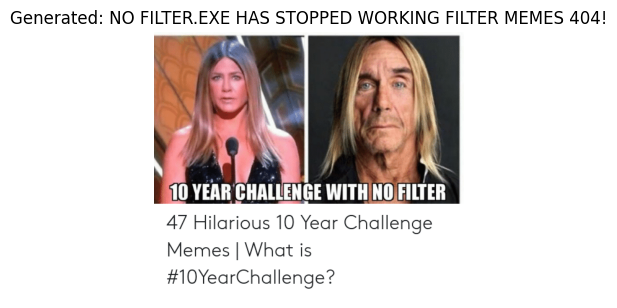


Sample 3:
Original: 1998: "Don't get in car with strangers" 2008: "Don't meet people from the internet alone." MemeCenter.com 2019: UBER.. Order yourself a stranger from the internet to get into a car with alone.
Generated: WHEN A STRANGER HAPPENS ALONE ORDER.
Humor: 0.90, Coherence: 0.5, Format: 1.0
Context Overlap: 0.16, Key Content Preserved: 0.27
Image path: /kaggle/input/6992-labeled-meme-images-dataset/images/images/image_6.jpg


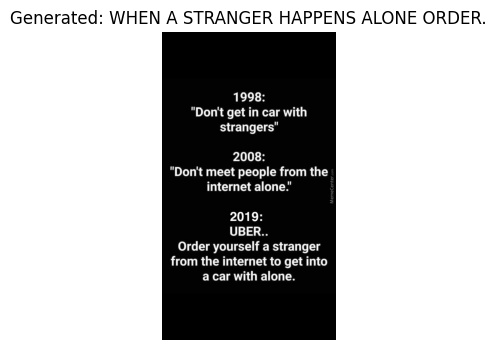


Sample 4:
Original: FACEBOOK '10 YEAR CHALLENGE': A PLOY OR A SIMPLE MEME? mo by eXo Hạ Minh Le 18 Jan 2018
Generated: POV: EXO HẠ MINH CHALLENGE YEAR.
Humor: 0.70, Coherence: 0.5, Format: 1.0
Context Overlap: 0.28, Key Content Preserved: 0.44
Image path: /kaggle/input/6992-labeled-meme-images-dataset/images/images/image_10.png


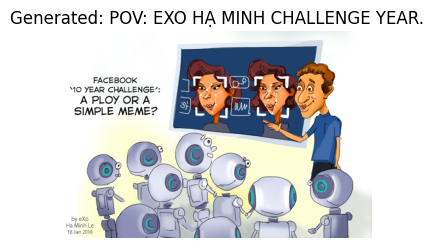


Sample 5:
Original: When you wakeup and read the messages you sent to actual family members instead of just friends while drunk
Generated: WHEN FAMILY MEMBERS READ GAME <UNK> DIES.
Humor: 0.90, Coherence: 0.5, Format: 1.0
Context Overlap: 0.22, Key Content Preserved: 0.33
Image path: /kaggle/input/6992-labeled-meme-images-dataset/images/images/image_17.jpg


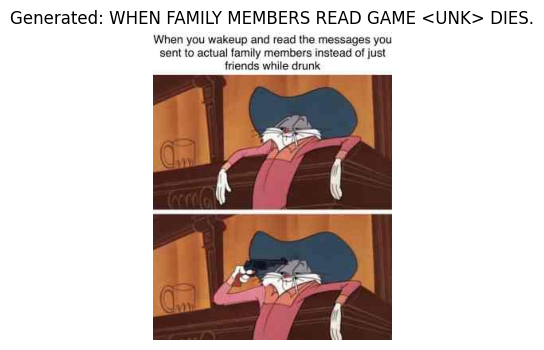


Sample 6:
Original: CAN'T WAIT TO SEE CAPTAIN MARVEL ON SCREEN FOR THE FIRST TIME AND ABOVE HIM IS SOME LADY CALLED CAROL DANVERS.
Generated: TFW SCREEN DANVERS WAIT CHUCK NORRIS TIME!
Humor: 0.70, Coherence: 0.5, Format: 1.0
Context Overlap: 0.18, Key Content Preserved: 0.36
Image path: /kaggle/input/6992-labeled-meme-images-dataset/images/images/image_35.png


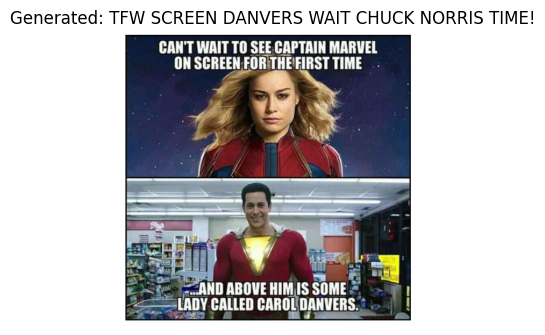


Sample 7:
Original: WHEN YOU'RE CREW IS AT SCHOOL AND ITS ABOUT TO GO DOWN WITH THE ONE YOU HATE
Generated: WHEN ABOUT 'RE SCHOOL BALL.
Humor: 0.90, Coherence: 0.5, Format: 1.0
Context Overlap: 0.24, Key Content Preserved: 0.40
Image path: /kaggle/input/6992-labeled-meme-images-dataset/images/images/image_55.jpg


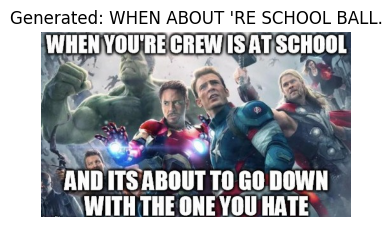


Sample 8:
Original: SEES AVENGERS MOVIE EARLY CREATES COMICS WITH SPOILERS AND PUTS THEM ON THE FRONT PAGE quickmeme.com
Generated: TFW FRONT PAGE QUICKMEME.COM SPOILERS AVENGERS MONEY.
Humor: 0.70, Coherence: 0.5, Format: 1.0
Context Overlap: 0.35, Key Content Preserved: 0.36
Image path: /kaggle/input/6992-labeled-meme-images-dataset/images/images/image_56.jpg


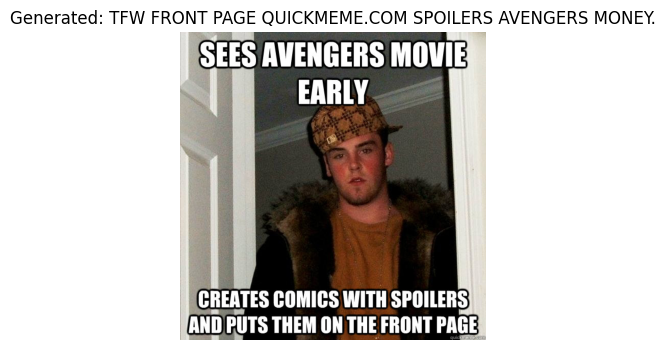


Sample 9:
Original: David 4 @itsdxvid The real reason Marvel moved the #Infinity War date forward was so these 3 had less time to give out spoilers I UNDERSTOOD THAT REFERENCE
Generated: THAT REFERENCE ENERGY MARVEL DATE MIKE MUST.
Humor: 0.50, Coherence: 0.5, Format: 0.7
Context Overlap: 0.15, Key Content Preserved: 0.17
Image path: /kaggle/input/6992-labeled-meme-images-dataset/images/images/image_65.jpg


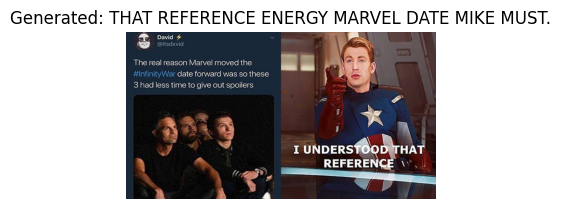


Sample 10:
Original: Ironman takes a dig at Spiderman
Generated: MISSION FAILED DIG IRONMAN GREATEST ALWAYS SPIDERMAN!
Humor: 0.50, Coherence: 0.5, Format: 0.7
Context Overlap: 0.50, Key Content Preserved: 0.75
Image path: /kaggle/input/6992-labeled-meme-images-dataset/images/images/image_67.jpg


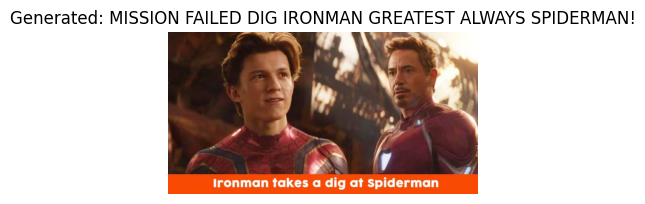


Evaluation Metrics:
Average Humor Score: 0.72
Average Context Overlap: 0.30
Average Key Content Preserved: 0.43
Average Coherence: 0.50
Average Format Score: 0.88
Overall Quality Score: 0.50

Interactive Test:
Original: I really need some coffee
Generated: NOBODY CARES ABOUT YOUR COFFEE NEED BOUGHT ENERGY EVERY!
Reward: 7.20, Humor: 0.50
Context Overlap: 0.40, Key Content Preserved: 1.00


[{'original': '10 Year Challenge - Sweet Dee Edition',
  'generated': 'DEE EDITION.EXE HAS STOPPED WORKING YEAR SWEET WORLD HAPPENS.',
  'humor_score': 0.7,
  'context_overlap': 0.6666666666666666,
  'key_content_preserved': 0.8,
  'coherence': 0.5,
  'format_score': 0.7},
 {'original': '10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious 10 Year Challenge Memes | What is #10 Year Challenge?',
  'generated': 'NO FILTER.EXE HAS STOPPED WORKING FILTER MEMES 404!',
  'humor_score': 0.7,
  'context_overlap': 0.2727272727272727,
  'key_content_preserved': 0.4,
  'coherence': 0.5,
  'format_score': 0.7},
 {'original': '1998: "Don\'t get in car with strangers" 2008: "Don\'t meet people from the internet alone." MemeCenter.com 2019: UBER.. Order yourself a stranger from the internet to get into a car with alone.',
  'generated': 'WHEN A STRANGER HAPPENS ALONE ORDER.',
  'humor_score': 0.8999999999999999,
  'context_overlap': 0.16,
  'key_content_preserved': 0.2727272727272727,
  'coherence': 0.5,
  

In [11]:
def evaluate_caption_quality(policy_net, test_data, word_to_idx, idx_to_word, 
                           modern_slang, starter_templates, context_phrases, n_samples=10):
    policy_net.eval()
    results = []
    total_samples = 0
    print("\nGenerating sample captions with enhanced context preservation...")
    valid_samples = []
    for row in test_data.iloc[:min(n_samples*5, len(test_data))].to_dict('records'):
        original = str(row.get('text_corrected', ''))
        if original and len(original.strip()) > 5:
            valid_samples.append(row)
            if len(valid_samples) >= n_samples:
                break
    for i, row in enumerate(valid_samples):
        total_samples += 1
        original = str(row.get('text_corrected', ''))
        generated, raw_reward = generate_highly_contextual_caption(
            original, policy_net, word_to_idx, idx_to_word,
            modern_slang, starter_templates, context_phrases)
        generated = postprocess_caption(generated)
        humor_score = predict_humor(generated)
        original_words = set(re.findall(r'\b\w+\b', original.upper()))
        generated_words = set(re.findall(r'\b\w+\b', generated.upper()))
        context_overlap = len(original_words.intersection(generated_words)) / len(original_words) if original_words else 0
        key_phrases, key_words = extract_contextual_phrases(original)
        key_words_set = set(key_words)
        key_preserved = len(key_words_set.intersection(generated_words)) / len(key_words_set) if key_words_set else 0
        coherence = 0.0
        try:
            pos_tags = nltk.pos_tag(generated.split())
            has_noun = any(tag.startswith('N') for _, tag in pos_tags)
            has_verb = any(tag.startswith('V') for _, tag in pos_tags)
            if has_noun and has_verb:
                coherence = 1.0
            elif has_noun or has_verb:
                coherence = 0.5
        except:
            pass
        format_score = 0.0
        if any(generated.startswith(prefix) for prefix in ["WHEN ", "TFW ", "POV: "]):
            format_score = 1.0
        elif "#" in generated or generated.isupper():
            format_score = 0.7
        print(f"\nSample {i+1}:")
        print(f"Original: {original}")
        print(f"Generated: {generated}")
        print(f"Humor: {humor_score:.2f}, Coherence: {coherence:.1f}, Format: {format_score:.1f}")
        print(f"Context Overlap: {context_overlap:.2f}, Key Content Preserved: {key_preserved:.2f}")
        try:
            image_path = f"/kaggle/input/6992-labeled-meme-images-dataset/images/images/{row['image_name']}"
            print(f"Image path: {image_path}")
            img = Image.open(image_path)
            plt.figure(figsize=(4, 4))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Generated: {generated}")
            plt.show()
        except:
            print("Image failed to load.")
        results.append({
            'original': original,
            'generated': generated,
            'humor_score': humor_score,
            'context_overlap': context_overlap,
            'key_content_preserved': key_preserved,
            'coherence': coherence,
            'format_score': format_score
        })
    if results:
        avg_humor = sum(r['humor_score'] for r in results) / len(results)
        avg_context = sum(r['context_overlap'] for r in results) / len(results)
        avg_key_preserved = sum(r['key_content_preserved'] for r in results) / len(results)
        avg_coherence = sum(r['coherence'] for r in results) / len(results)
        avg_format = sum(r['format_score'] for r in results) / len(results)
        print("\nEvaluation Metrics:")
        print(f"Average Humor Score: {avg_humor:.2f}")
        print(f"Average Context Overlap: {avg_context:.2f}")
        print(f"Average Key Content Preserved: {avg_key_preserved:.2f}")
        print(f"Average Coherence: {avg_coherence:.2f}")
        print(f"Average Format Score: {avg_format:.2f}")
        overall_score = (avg_humor * 0.2 + avg_context * 0.3 + avg_key_preserved * 0.3 +
                         avg_coherence * 0.1 + avg_format * 0.1)
        print(f"Overall Quality Score: {overall_score:.2f}")
    text = "I really need some coffee"
    generated, reward = generate_highly_contextual_caption(
        text, policy_net, word_to_idx, idx_to_word, modern_slang, starter_templates, context_phrases)
    generated = postprocess_caption(generated)
    humor = predict_humor(generated)
    original_words = set(re.findall(r'\b\w+\b', text.upper()))
    generated_words = set(re.findall(r'\b\w+\b', generated.upper()))
    context_overlap = len(original_words.intersection(generated_words)) / len(original_words) if original_words else 0
    _, key_words = extract_contextual_phrases(text)
    key_words_set = set(key_words)
    key_preserved = len(key_words_set.intersection(generated_words)) / len(key_words_set) if key_words_set else 0
    print(f"\nInteractive Test:")
    print(f"Original: {text}")
    print(f"Generated: {generated}")
    print(f"Reward: {reward:.2f}, Humor: {humor:.2f}")
    print(f"Context Overlap: {context_overlap:.2f}, Key Content Preserved: {key_preserved:.2f}")
    return results

evaluate_caption_quality(policy_net, test_df, word_to_idx, idx_to_word,
                        modern_slang, starter_templates, context_phrases)

In [2]:
pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-0188kk6u
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-0188kk6u
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=013a413eb7b85713ec94c7a12f1cd13d0f3d43e934f8e3e1f6fab0f4975fb0e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-pp1h8pbb/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
Note: you may need to restart the kernel to use updated packages.


In [25]:
!pip install transformers

In [9]:
!pip install nltk rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=fa30aa21c3251843e5dc4f4162a68074ef915b06bbee5ad631324181ce85db83
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


Imports loaded, device: cuda
Enhanced model architecture defined!


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Filtered humor dataset: 325 entries (from 600)
Vocabulary size: 2260
Sample vocabulary words: ['SPORT', 'DATA', 'EXPLODED', 'SHIELD', 'QUESTION', 'IT!"', 'EVERYONE', 'POV:', 'AWKWARD', 'USE', 'GUN', 'GRASS', 'TWO', 'ZUCKERBERG', 'COULD', 'POWERFUL', 'THOUGHTS', 'TECH', 'KICK', "THEY'RE"]
Found 6989 images at /kaggle/input/6992-labeled-meme-images-dataset/images/images
Processing 6989 images...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Error processing /kaggle/input/6992-labeled-meme-images-dataset/images/images/image_5119.png: image file is truncated
Image names in keywords: ['image_5576.jpg', 'image_6267.jpg', 'image_747.jpg', 'image_5775.jpg', 'image_561.jpg']
Train image_name sample: ['image_4499.jpg', 'image_3937.jpeg', 'image_5060.jpg', 'image_1380.jpg', 'image_3871.png']
Train columns: ['Unnamed: 0', 'image_name', 'text_ocr', 'text_corrected', 'overall_sentiment', 'image_keywords']
Train keywords sample: [['CELEBRITY', 'HERO', 'SUPERHERO', 'SAVIOR', 'MEME', 'VIRAL', 'JOKE', 'POLITICIAN', 'MOVIE', 'FILM', 'CINEMA'], ['KID', 'CHILD', 'YOUNG', 'CELEBRITY', 'BABY', 'INFANT', 'CONFUSED', 'WHAT', 'HUH', 'DISAPPOINTED', 'LETDOWN', 'SIGH'], ['MEME', 'VIRAL', 'JOKE', 'SUPERHERO', 'HERO', 'SAVIOR', 'POLITICIAN', 'GAME', 'GAMING', 'PLAYER']]
Test keywords sample: [['CHALLENGE', 'DIFFICULT', 'TRYING', 'SURPRISED PERSON'], ['CHALLENGE', 'DIFFICULT', 'TRYING'], ['INTERNET', 'ONLINE', 'WEB', 'SOCIAL', 'INFLUENCER', 'MEME', '

Generating sample captions:   0%|          | 0/10 [00:00<?, ?it/s]

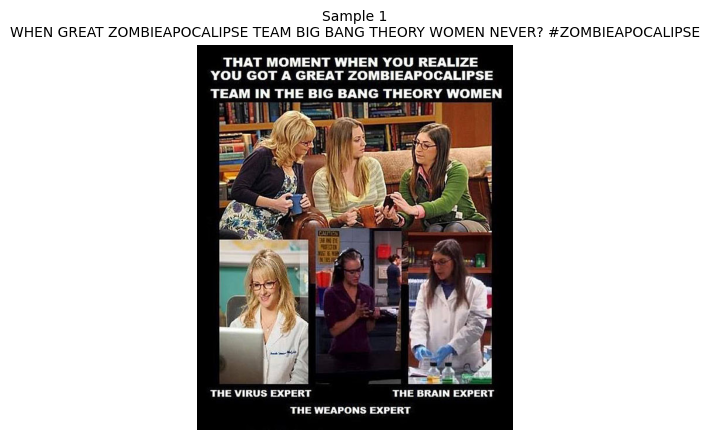

Generating sample captions:  10%|█         | 1/10 [00:00<00:01,  5.36it/s]


Sample 1:
Original Text: that moment when you realize you got a great zombieapocalipse team in the big bang theory women calvin bende te the virus expert the brain expert the weapons expert
Generated Caption: WHEN GREAT ZOMBIEAPOCALIPSE TEAM BIG BANG THEORY WOMEN NEVER? #ZOMBIEAPOCALIPSE
Humor: 1.54, Coherence: 1.00, Format: 1.00
Context Overlap: 0.28, Key Content Preserved: 1.00, Image Match: 0.08
BLEU: 0.0769
Reward: 9.77


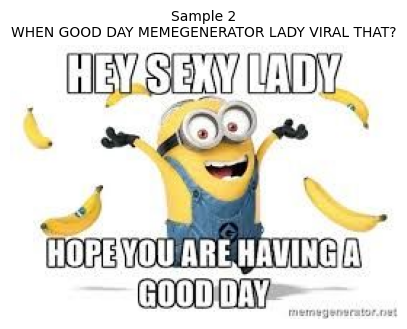

Generating sample captions:  20%|██        | 2/10 [00:00<00:01,  6.44it/s]


Sample 2:
Original Text: hey sexy lady oo the hope you are having a good day memegenerator
Generated Caption: WHEN GOOD DAY MEMEGENERATOR LADY VIRAL THAT?
Humor: 1.64, Coherence: 1.00, Format: 1.00
Context Overlap: 0.31, Key Content Preserved: 1.00, Image Match: 0.29
BLEU: 0.1379
Reward: 9.65


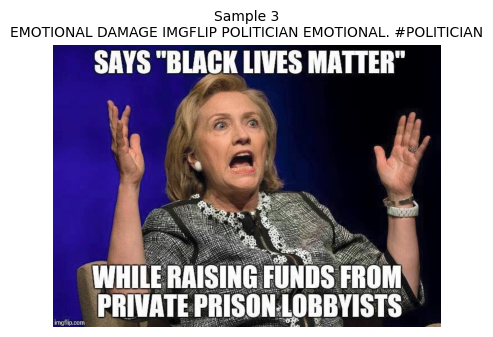

Generating sample captions:  30%|███       | 3/10 [00:00<00:01,  6.30it/s]


Sample 3:
Original Text: says "black lives matter" while raising funds from private prison lobbyists imgflip
Generated Caption: EMOTIONAL DAMAGE IMGFLIP POLITICIAN EMOTIONAL. #POLITICIAN
Humor: 1.60, Coherence: 1.00, Format: 1.00
Context Overlap: 0.08, Key Content Preserved: 0.70, Image Match: 1.00
BLEU: 0.0936
Reward: 4.40


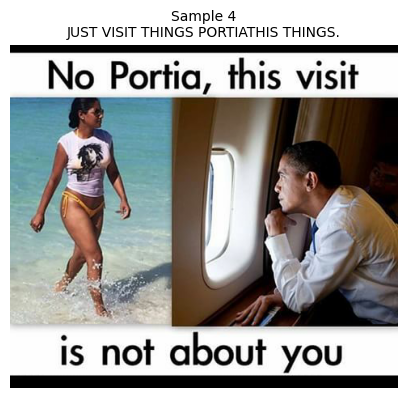

Generating sample captions:  40%|████      | 4/10 [00:00<00:00,  6.02it/s]


Sample 4:
Original Text: no portiathis visit isn't about you
Generated Caption: JUST VISIT THINGS PORTIATHIS THINGS.
Humor: 0.90, Coherence: 1.00, Format: 0.70
Context Overlap: 0.33, Key Content Preserved: 1.00, Image Match: 0.00
BLEU: 0.2009
Reward: 5.89


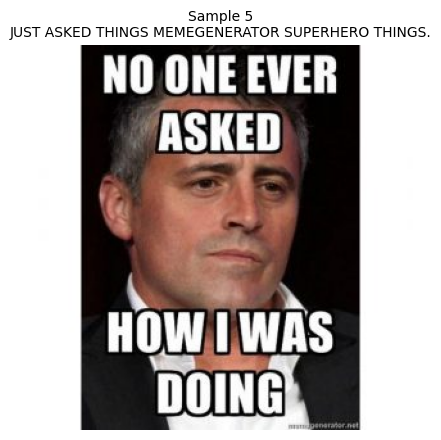

Generating sample captions:  50%|█████     | 5/10 [00:00<00:00,  6.36it/s]


Sample 5:
Original Text: no one ever asked how i was doing memegenerator
Generated Caption: JUST ASKED THINGS MEMEGENERATOR SUPERHERO THINGS.
Humor: 1.09, Coherence: 1.00, Format: 0.70
Context Overlap: 0.22, Key Content Preserved: 0.70, Image Match: 0.38
BLEU: 0.1780
Reward: 6.29


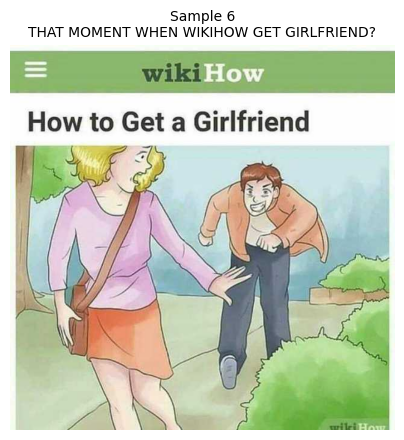

Generating sample captions:  60%|██████    | 6/10 [00:00<00:00,  6.01it/s]


Sample 6:
Original Text: wikihow how to get a girlfriend wikihow
Generated Caption: THAT MOMENT WHEN WIKIHOW GET GIRLFRIEND?
Humor: 1.50, Coherence: 1.00, Format: 1.00
Context Overlap: 0.29, Key Content Preserved: 1.00, Image Match: 0.00
BLEU: 0.2621
Reward: 7.21


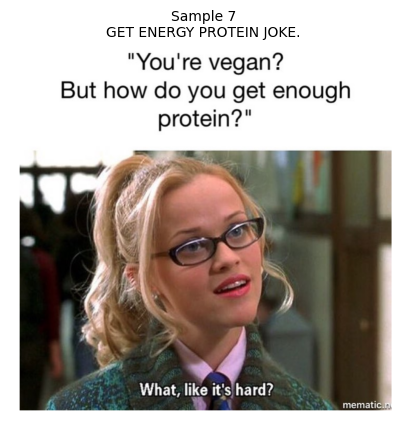

Generating sample captions:  70%|███████   | 7/10 [00:01<00:00,  5.37it/s]


Sample 7:
Original Text: you're vegan? but how do you get enough protein? whatlike it's hard mematic.n
Generated Caption: GET ENERGY PROTEIN JOKE.
Humor: 1.08, Coherence: 0.80, Format: 0.70
Context Overlap: 0.08, Key Content Preserved: 0.70, Image Match: 0.17
BLEU: 0.0214
Reward: 4.15


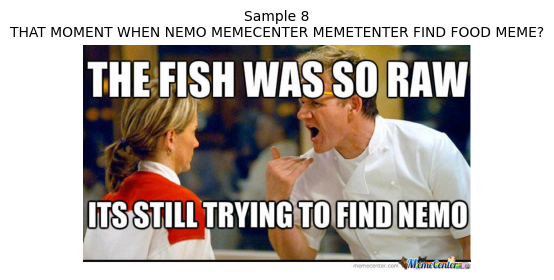

Generating sample captions:  80%|████████  | 8/10 [00:01<00:00,  5.61it/s]


Sample 8:
Original Text: the fish was so raw its still trying to find nemo memecenter memetenter
Generated Caption: THAT MOMENT WHEN NEMO MEMECENTER MEMETENTER FIND FOOD MEME?
Humor: 1.57, Coherence: 1.00, Format: 1.00
Context Overlap: 0.31, Key Content Preserved: 0.70, Image Match: 0.13
BLEU: 0.1595
Reward: 9.11


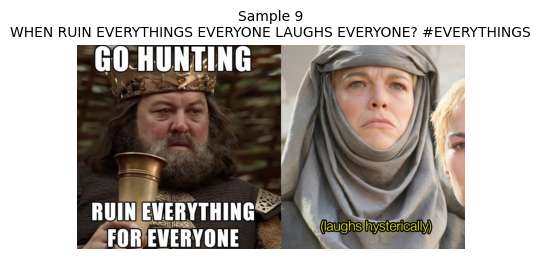

Generating sample captions:  90%|█████████ | 9/10 [00:01<00:00,  4.83it/s]


Sample 9:
Original Text: go hunting ruin everythings for everyone (laughs hysterically )
Generated Caption: WHEN RUIN EVERYTHINGS EVERYONE LAUGHS EVERYONE? #EVERYTHINGS
Humor: 1.50, Coherence: 1.00, Format: 1.00
Context Overlap: 0.33, Key Content Preserved: 1.00, Image Match: 0.00
BLEU: 0.1993
Reward: 9.37


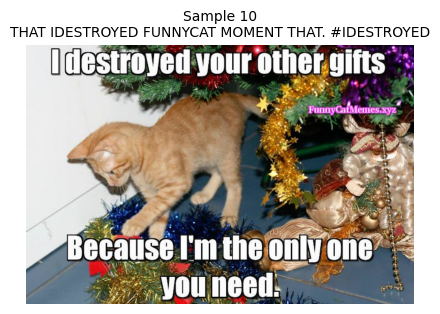

Generating sample captions: 100%|██████████| 10/10 [00:01<00:00,  5.54it/s]



Sample 10:
Original Text: idestroyed your other gifts** funnycat memes because i'm the only one you need
Generated Caption: THAT IDESTROYED FUNNYCAT MOMENT THAT. #IDESTROYED
Humor: 1.16, Coherence: 1.00, Format: 1.00
Context Overlap: 0.15, Key Content Preserved: 1.00, Image Match: 0.11
BLEU: 0.1113
Reward: 5.95


Generating all captions (no print): 100%|██████████| 1398/1398 [00:17<00:00, 80.76it/s]



Evaluation Metrics:
Average Humor Score: 1.26
Average Coherence: 0.96
Average Format Score: 0.91
Average Context Overlap: 0.22
Average Key Content Preserved: 0.87
Average Image Match: 0.10
Average BLEU Score: 0.1184
Average Reward: 6.63
Overall Quality Score: 0.58
Saved 1408 captions to /kaggle/working/captions.csv

Additional Evaluation Metrics:
Average BLEU Score: 0.1184


In [12]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
import re
from PIL import Image
import matplotlib.pyplot as plt
import clip
from pathlib import Path
from tqdm import tqdm
from rouge_score import rouge_scorer  # Add this
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction  # Add this

# NLTK setup
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('stopwords', quiet=True)

# Set seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Imports loaded, device:", device)

# Cell 1: Model Architecture
class ImprovedPolicyNetwork(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512, attention_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, attention_dim)
        self.attention_combine = nn.Linear(attention_dim, 1)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout = nn.Dropout(0.3)
        self.hidden_dim = hidden_dim
        
    def attention_mechanism(self, lstm_output):
        attention_weights = torch.tanh(self.attention(lstm_output))
        attention_weights = self.attention_combine(attention_weights)
        attention_weights = F.softmax(attention_weights, dim=1)
        context = attention_weights * lstm_output
        return context.sum(dim=1)
        
    def forward(self, input_ids, hidden=None):
        batch_size = input_ids.size(0)
        embeds = self.embedding(input_ids)
        embeds = self.dropout(embeds)
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        if input_ids.size(1) > 1:
            attn_out = self.attention_mechanism(lstm_out)
            logits = self.fc(attn_out.unsqueeze(1).repeat(1, input_ids.size(1), 1))
        else:
            logits = self.fc(lstm_out)
            
        return logits, hidden

class ImprovedValueNetwork(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, input_ids, hidden=None):
        embeds = self.embedding(input_ids)
        embeds = self.dropout(embeds)
        lstm_out, hidden = self.lstm(embeds, hidden)
        value = self.fc(lstm_out[:, -1, :])
        return value, hidden

print("Enhanced model architecture defined!")

# Cell 2: Text Processing Functions
from collections import Counter
stop_words = set(stopwords.words('english'))

def extract_contextual_phrases(text):
    text = str(text).lower().strip()
    if not text:
        return [], []
    try:
        sentences = nltk.sent_tokenize(text)
    except:
        sentences = [text]
    all_phrases = []
    key_words = []
    
    for sentence in sentences:
        try:
            tokens = nltk.word_tokenize(sentence)
            filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
            pos_tags = nltk.pos_tag(filtered_tokens)
            
            nouns = [word.upper() for word, tag in pos_tags if tag.startswith('N') and len(word) > 2 and not word.isdigit()]
            verbs = [word.upper() for word, tag in pos_tags if tag.startswith('V') and len(word) > 2 and word not in ['IS', 'ARE', 'WAS', 'WERE']]
            adjs = [word.upper() for word, tag in pos_tags if tag.startswith('J') and len(word) > 2]
            
            key_words.extend(nouns + verbs + adjs)
            
            i = 0
            while i < len(pos_tags) - 1:
                if (pos_tags[i][1].startswith('J') and pos_tags[i+1][1].startswith('N')) or \
                   (pos_tags[i][1] in ('DT', 'PRP$') and pos_tags[i+1][1].startswith('N')):
                    phrase = pos_tags[i][0] + " " + pos_tags[i+1][0]
                    j = i + 2
                    while j < len(pos_tags) and pos_tags[j][1].startswith(('J', 'N')):
                        phrase += " " + pos_tags[j][0]
                        j += 1
                    if len(phrase.split()) >= 2:
                        all_phrases.append(phrase.upper())
                    i = j
                else:
                    i += 1
                    
            for i in range(len(pos_tags) - 2):
                if pos_tags[i][1].startswith(('N', 'PRP')) and \
                   pos_tags[i+1][1].startswith('V') and \
                   i+2 < len(pos_tags) and pos_tags[i+2][1].startswith(('N', 'PRP', 'J')):
                    phrase = pos_tags[i][0] + " " + pos_tags[i+1][0] + " " + pos_tags[i+2][0]
                    all_phrases.append(phrase.upper())
        except:
            words = sentence.split()
            if words:
                key_words.extend([w.upper() for w in words if len(w) > 2 and w.isalnum() and w.lower() not in stop_words])
                if len(words) >= 3:
                    for i in range(len(words) - 2):
                        all_phrases.append(" ".join(words[i:i+3]).upper())
    
    key_words = list(dict.fromkeys(key_words))
    all_phrases = list(dict.fromkeys(all_phrases))
    
    all_phrases = sorted(all_phrases, key=lambda x: len(x.split()), reverse=True)[:8]
    key_words = sorted(key_words, key=lambda x: len(x))[:15]
    
    return all_phrases, key_words

def clean_ocr_text(text):
    text = str(text)
    patterns = [
        r'https?://\S+', r'www\.\S+', r'\.com\b', r'\.net\b', r'\.xyz\b',
        r'by\s+\S+', r'\d{4}-\d{2}-\d{2}', r'\d{2}\s+[A-Za-z]{3}\s+\d{4}',
        r'memecenter\.com', r'quickmeme\.com', r'@\S+', r'#\d+',
        r'\b(?:jpg|png|gif)\b', r'\[\s*\]', r'\(\s*\)', r'\s{2,}'
    ]
    for pattern in patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    
    text = text.lower()
    text = text.replace("'", "'").replace(""", '"').replace(""", '"')
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text if text else "unknown"

def generate_contextual_meme_template(original_text, context_phrases, starter_templates):
    contextual_phrases, key_words = extract_contextual_phrases(original_text)
    
    if contextual_phrases and len(contextual_phrases) >= 1 and random.random() < 0.8:
        phrase = contextual_phrases[0] if len(contextual_phrases) > 0 else key_words[0] if key_words else "MEME"
        phrase_words = phrase.split()
        
        if len(phrase_words) >= 3:
            templates = [
                f"WHEN {phrase} ",
                f"TFW {phrase} ",
                f"ME WHEN {phrase} ",
                f"POV: {phrase} ",
                f"{phrase} BE LIKE: ",
                f"NOBODY:\nME: {phrase} ",
                f"THAT MOMENT WHEN {phrase} "
            ]
        elif len(phrase_words) == 2:
            templates = [
                f"WHEN {phrase} HAPPENS ",
                f"{phrase_words[0]} {phrase_words[1]} ENERGY ",
                f"MY {phrase} WHEN ",
                f"THAT {phrase} MOMENT ",
                f"EVERYONE'S {phrase} FACE WHEN "
            ]
        else:
            word = phrase_words[0]
            templates = [
                f"WHEN THE {word} ",
                f"{word} MOOD ",
                f"THAT {word} FEELING ",
                f"{word} INTENSIFIES ",
                f"JUST {word} THINGS "
            ]
        template = random.choice(templates)
    elif key_words and random.random() < 0.7:
        word = key_words[0] if key_words else "MEME"
        templates = [
            f"WHEN {word} ",
            f"TFW {word} ",
            f"MY {word} BE LIKE: ",
            f"JUST {word} THINGS ",
            f"NOBODY CARES ABOUT YOUR {word} ",
            f"{word} ENERGY "
        ]
        template = random.choice(templates)
    else:
        template = random.choice(starter_templates)
    
    return template, contextual_phrases, key_words

def postprocess_caption(caption):
    words = caption.split()
    
    cleaned = []
    prev_word = None
    for word in words:
        if word != prev_word and word != "<UNK>" and word != "<END>" and word != "<START>":
            cleaned.append(word)
            prev_word = word
    
    caption = " ".join(cleaned)
    
    caption = re.sub(r'YOU\s+YOU', 'YOU', caption)
    caption = re.sub(r'ME\s+ME', 'ME', caption)
    caption = re.sub(r'WHEN\s+WHEN', 'WHEN', caption)
    caption = re.sub(r'THE\s+THE', 'THE', caption)
    
    caption = re.sub(r'\b(AND|THE|A|OF|TO|FOR|IN|ON|BY)\s*$', '', caption, flags=re.IGNORECASE)
    
    caption = re.sub(r'\s+([.,!?:;])', r'\1', caption)
    
    if len(caption.split()) < 3:
        caption = f"{caption} VIBES" if caption else "TFW MEME VIBES"
    
    if len(caption) >= 5 and caption[-1] not in ".!?":
        if "?" in caption or any(w in caption for w in ["WHO", "WHAT", "WHERE", "WHEN", "WHY", "HOW"]):
            caption += "?"
        elif any(word in caption.upper() for word in ["FAIL", "BAD", "TERRIBLE", "NO", "CAN'T", "OMG", "WOW"]):
            caption += "!"
        else:
            caption += "."
    
    if random.random() < 0.4 and "#" not in caption:
        caption_words = caption.split()
        if caption_words:
            strong_words = [w for w in caption_words if len(w) > 3 and w not in ["WHEN", "THAT", "THIS", "LIKE"]]
            if strong_words:
                strongest_word = max(strong_words, key=len)
                caption += f" #{strongest_word.upper()}"
    
    return caption.strip()

def predict_humor(text):
    words = text.split()
    humor_score = 0.5
    
    modern_slang = [
        "YEET", "OOF", "BRUH", "SUS", "BASED", "NO CAP", "SHEESH", "SLAY", "VIBE CHECK", "SIMP", "STAN",
        "CHAD", "KAREN", "BOOMER", "ZOOMER", "SIGMA", "ALPHA", "MATERIAL GIRL", "UNDERSTOOD THE ASSIGNMENT",
        "MAIN CHARACTER", "VILLAIN ERA", "CORE", "CODED", "UNSERIOUS", "MOTHER", "FATHER", "MOTHERING",
        "FATHERING", "BANGER", "SLEPT ON", "RENT FREE", "LIVES IN MY HEAD", "GASLIGHT", "GATEKEEP",
        "GIRLBOSS", "CAUGHT IN 4K", "RIZZ", "NO RIZZ", "UNHINGED", "LIVING MY BEST LIFE", "GIVING",
        "SERVED", "ATE", "LEFT NO CRUMBS", "404", "HOTFIX", "SENDHELP", "VIBES", "ENERGY", "MAIN CHARACTER",
        "VILLAIN ERA", "DELULU", "CORE", "CODED", "UNSERIOUS"
    ]
    
    if any(text.startswith(prefix) for prefix in ["WHEN ", "TFW ", "POV:", "NO ONE:", "ME WHEN ", "THAT MOMENT WHEN"]):
        humor_score += 0.4
    
    if "#" in text:
        humor_score += 0.2
    
    if any(word in modern_slang for word in words):
        humor_score += 0.3
    
    if "BUT" in words or "WHEN" in words or "UNTIL" in words or "SUDDENLY" in words:
        humor_score += 0.3
    
    if "404" in words or "HOTFIX" in words or ".EXE" in text or "LOADING" in words:
        humor_score += 0.3
    
    if "<UNK>" in words or "<END>" in words or "<START>" in words:
        humor_score -= 0.5
    
    if len(words) < 3:
        humor_score -= 0.4
        
    if 5 <= len(words) <= 12:
        humor_score += 0.2
        
    if text.isupper():
        humor_score += 0.2
        
    return min(1.5, max(0.1, humor_score))

# Cell 3: Enhanced Data Processing
def filter_and_cluster_data(humor_df, min_humor_score=0.6, num_clusters=12):
    humor_scores = [predict_humor(text) for text in humor_df['text']]
    humor_df['humor_score'] = humor_scores
    filtered_df = humor_df[humor_df['humor_score'] >= min_humor_score].copy()
    
    filtered_df = filtered_df[filtered_df['text'].apply(lambda x: 3 <= len(str(x).split()) <= 20)]
    
    texts = filtered_df['text'].tolist()
    if len(texts) > 100:
        vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
        X = vectorizer.fit_transform(texts)
        
        kmeans = KMeans(n_clusters=min(num_clusters, len(texts) // 10), random_state=42)
        clusters = kmeans.fit_predict(X)
        filtered_df['cluster'] = clusters
        
        balanced_df = pd.DataFrame()
        for cluster_id in range(kmeans.n_clusters):
            cluster_samples = filtered_df[filtered_df['cluster'] == cluster_id]
            if len(cluster_samples) > 100:
                cluster_samples = cluster_samples.sample(100, random_state=42)
            balanced_df = pd.concat([balanced_df, cluster_samples])
            
        filtered_df = balanced_df
    else:
        filtered_df['cluster'] = 0
        
    print(f"Filtered humor dataset: {len(filtered_df)} entries (from {len(humor_df)})")
    return filtered_df

def extract_clip_features(image_paths, clip_model, preprocess, device, batch_size=16):
    image_keywords = {}
    
    meme_objects = [
        "coffee mug", "car", "cat", "dog", "phone", "laptop", "hero", "spider-man", "sad face",
        "party", "food", "pizza", "burger", "cake", "baby", "kid", "couple", "team", "zombie",
        "school", "work", "money", "tv", "game", "comic", "movie", "internet", "meme", "challenge",
        "confused face", "shocked expression", "surprised person", "happy celebration", "angry face",
        "disappointed look", "frustration", "excitement", "dance", "sports", "classroom", "office",
        "business meeting", "family", "friends", "celebrity", "politician", "superhero", "cartoon",
        "computer", "social media", "selfie", "group photo", "funny pose", "reaction"
    ]
    
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {obj}") for obj in meme_objects]).to(device)
    with torch.no_grad():
        text_features = clip_model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    
    print(f"Processing {len(image_paths)} images...")
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []
        valid_paths = []
        for img_path in batch_paths:
            try:
                image = Image.open(img_path).convert("RGB")
                batch_images.append(preprocess(image))
                valid_paths.append(img_path)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                image_keywords[Path(img_path).name] = ["unknown"]
        
        if not batch_images:
            continue
            
        try:
            image_inputs = torch.stack(batch_images).to(device)
            with torch.no_grad():
                image_features = clip_model.encode_image(image_inputs)
                image_features /= image_features.norm(dim=-1, keepdim=True)
                
            logits = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            top_probs, top_indices = logits.topk(5, dim=-1)
            
            for idx, img_path in enumerate(valid_paths):
                significant_indices = [i for i, prob in zip(top_indices[idx], top_probs[idx]) if prob > 0.05]
                keywords = [meme_objects[i] for i in significant_indices]
                image_keywords[Path(img_path).name] = keywords or ["unknown"]
        except Exception as e:
            print(f"CLIP batch error at {i}: {e}")
            for img_path in valid_paths:
                image_keywords[Path(img_path).name] = ["unknown"]
                
    return image_keywords

def get_dummy_keywords(text):
    text = str(text).lower()
    keyword_map = {
        "coffee": ["COFFEE", "CAFFEINE", "MORNING"], 
        "car": ["CAR", "DRIVING", "VEHICLE"],
        "cat": ["CAT", "KITTEN", "FELINE"],
        "dog": ["DOG", "PUPPY", "GOODBOI"],
        "phone": ["PHONE", "TEXT", "CALL"],
        "fail": ["FAIL", "MISTAKE", "OOPS"],
        "win": ["WIN", "SUCCESS", "VICTORY"],
        "hero": ["HERO", "SUPERHERO", "BRAVE"],
        "work": ["WORK", "JOB", "OFFICE"],
        "school": ["SCHOOL", "CLASS", "EDUCATION"],
        "friend": ["FRIEND", "BUDDY", "PAL"],
        "sad": ["SAD", "UNHAPPY", "CRYING"]
    }
    
    for key, keywords in keyword_map.items():
        if key in text:
            return keywords
    return ["MEME", "FUNNY", "REACTION"]

def map_image_keywords(image_keywords):
    keyword_map = {
        "coffee mug": ["COFFEE", "MUG", "CAFFEINE"], 
        "car": ["CAR", "DRIVING", "VEHICLE"],
        "cat": ["CAT", "KITTEN", "FELINE"],
        "dog": ["DOG", "PUPPY", "GOODBOI"],
        "phone": ["PHONE", "TEXT", "CALL"],
        "laptop": ["LAPTOP", "COMPUTER", "WORK"],
        "hero": ["HERO", "SUPERHERO", "SAVIOR"],
        "spider-man": ["SPIDERMAN", "WEBSLINGER", "MARVEL"],
        "sad face": ["SAD", "DEPRESSED", "CRYING"],
        "confused face": ["CONFUSED", "WHAT", "HUH"],
        "shocked expression": ["SHOCKED", "SURPRISE", "OMG"],
        "party": ["PARTY", "CELEBRATION", "FUN"],
        "food": ["FOOD", "EATING", "HUNGRY"],
        "pizza": ["PIZZA", "SLICE", "CHEESY"],
        "burger": ["BURGER", "FASTFOOD", "HUNGRY"],
        "cake": ["CAKE", "DESSERT", "BIRTHDAY"],
        "baby": ["BABY", "INFANT", "CHILD"],
        "kid": ["KID", "CHILD", "YOUNG"],
        "couple": ["COUPLE", "RELATIONSHIP", "LOVE"],
        "team": ["TEAM", "SQUAD", "GROUP"],
        "zombie": ["ZOMBIE", "UNDEAD", "APOCALYPSE"],
        "school": ["SCHOOL", "CLASS", "EDUCATION"],
        "work": ["WORK", "JOB", "CAREER"],
        "money": ["MONEY", "CASH", "RICH"],
        "tv": ["TV", "SHOW", "WATCHING"],
        "game": ["GAME", "GAMING", "PLAYER"],
        "comic": ["COMIC", "SUPERHERO", "PANEL"],
        "movie": ["MOVIE", "FILM", "CINEMA"],
        "internet": ["INTERNET", "ONLINE", "WEB"],
        "meme": ["MEME", "VIRAL", "JOKE"],
        "challenge": ["CHALLENGE", "DIFFICULT", "TRYING"],
        "happy celebration": ["HAPPY", "CELEBRATION", "PARTY"],
        "angry face": ["ANGRY", "MAD", "RAGE"],
        "disappointed look": ["DISAPPOINTED", "LETDOWN", "SIGH"],
        "frustration": ["FRUSTRATED", "ANNOYED", "ARGH"],
        "excitement": ["EXCITED", "HYPE", "THRILLED"],
        "office": ["OFFICE", "WORKPLACE", "CORPORATE"],
        "classroom": ["CLASSROOM", "SCHOOL", "STUDENT"],
        "family": ["FAMILY", "RELATIVES", "HOME"],
        "friends": ["FRIENDS", "SQUAD", "HOMIES"],
        "social media": ["SOCIAL", "ONLINE", "INFLUENCER"],
        "computer": ["COMPUTER", "TECH", "DIGITAL"],
        "reaction": ["REACTION", "RESPONDING", "FACE"]
    }
    
    mapped_keywords = {}
    for img_name, objects in image_keywords.items():
        keywords = []
        for obj in objects:
            keywords.extend(keyword_map.get(obj, [obj.upper()]))
        
        mapped_keywords[img_name] = list(dict.fromkeys(keywords)) or ["MEME"]
        
    return mapped_keywords

def build_enhanced_vocabulary(train_df, humor_df):
    modern_meme_phrases = [
        "WHEN YOU", "TFW", "POV:", "BRUH MOMENT", "ERROR 404", "BIG OOF", "YEET MODE",
        "INSTANT REGRET", "IT'S GIVING", "MAIN CHARACTER", "VILLAIN ERA", "NO THOUGHTS",
        "HEAD EMPTY", "JUST VIBING", "NO CONTEXT", "ZERO CHILL", "TOUCH GRASS", "BROKE IRL",
        "IN MY FEELS", "DEAD INSIDE", "WIFI LOST", "SUS ALERT", "RATIO", "BIG SAD",
        "NPC ENERGY", "THIS AIN'T IT", "404 BRAIN", "SPEEDRUN LIFE", "LOW EFFORT",
        "MY LAST BRAINCELL", "ERROR LOADING", "SYSTEM FAILURE", "BRAIN.EXE STOPPED",
        "INTERNAL SCREAMING", "VISIBLE CONFUSION", "TASK FAILED", "MISSION FAILED",
        "CONNECTION LOST", "EMOTIONAL DAMAGE", "CLOWN BEHAVIOR", "HOTFIX MY INPUT",
        "COFFEE CRASH", "ZOMBIE MODE", "ME WHEN INPUT", "TFW INPUT HAPPENS",
        "DELULU", "UNSERIOUS", "LIVING MY BEST LIFE", "SLAY", "THAT FEELING WHEN",
        "NO ONE:", "EVERYONE:", "ME:", "ABSOLUTELY NO ONE:", "POV YOU'RE",
        "NOBODY ASKED", "HERE'S YOUR SIGN", "TELL ME WITHOUT TELLING ME",
        "NOT ME", "THE FACT THAT", "THIS IS YOUR SIGN TO", "THE WAY THAT",
        "GIVING VERY MUCH", "EXACTLY WHAT I ORDERED VS WHAT I GOT"
    ]
    
    context_phrases = [
        "ME AT WORK", "ME AT 3 AM", "MY BRAIN", "MY BANK ACCOUNT", "MY LAST BRAINCELL",
        "EVERYONE ELSE", "MY FRIENDS", "SOCIETY", "MY PROFESSOR", "MY BOSS",
        "MY PARENTS", "THE INTERNET", "GAMERS", "INTROVERTS", "EXTROVERTS",
        "MY RESUME", "MY SEARCH HISTORY", "MY SPOTIFY", "MY CAMERA ROLL",
        "MONDAY MORNINGS", "FRIDAY NIGHT", "WEEKEND PLANS", "DURING THE MEETING",
        "MY PORTFOLIO", "MY GAMING SKILLS", "MY COOKING", "CUSTOMER SERVICE",
        "TECH SUPPORT", "GROUP PROJECTS", "SOCIAL ANXIETY", "MY DIET",
        "MY FITNESS ROUTINE", "ONLINE SHOPPING", "DATING APPS", "SOCIAL MEDIA",
        "WORKING FROM HOME", "ZOOM CALLS", "MY FACE", "MY EXPECTATIONS",
        "MY REALITY", "ADULTING", "MY PAYCHECK", "THE ASSIGNMENT"
    ]
    
    emotion_states = [
        "PAIN", "VOID", "CHAOS", "CRISIS", "EMPTY", "LOADING", "BROKEN", "FAILED",
        "CURSED", "BUFFERING", "CORRUPTED", "CRASHED", "GLITCHED", "REBOOT",
        "FROZEN", "LAGGING", "DELETED", "EXPLODED", "SCREAMING", "VIBING",
        "FOCUSING", "SUCCEEDING", "WINNING", "GAMING", "GRINDING", "LEVELING",
        "ASCENDING", "ENLIGHTENED", "THRIVING", "BLESSED", "STUNNED", "SHOOK",
        "CONFUSED", "ANGRY", "HAPPY", "EXCITED", "FRUSTRATED", "EXHAUSTED",
        "STRESSED", "CALM", "PANICKING", "DYING", "CRYING", "LAUGHING",
        "YELLING", "SIGHING", "WAITING", "HOPING", "EXPECTING", "WONDERING"
    ]
    
    modern_slang = [
        "YEET", "OOF", "BRUH", "SUS", "BASED", "NO CAP", "SHEESH", "SLAY", "VIBE CHECK", "SIMP", "STAN",
        "CHAD", "KAREN", "BOOMER", "ZOOMER", "SIGMA", "ALPHA", "MATERIAL GIRL", "UNDERSTOOD THE ASSIGNMENT",
        "MAIN CHARACTER", "VILLAIN ERA", "CORE", "CODED", "UNSERIOUS", "MOTHER", "FATHER", "MOTHERING",
        "FATHERING", "BANGER", "SLEPT ON", "RENT FREE", "LIVES IN MY HEAD", "GASLIGHT", "GATEKEEP",
        "GIRLBOSS", "CAUGHT IN 4K", "RIZZ", "NO RIZZ", "UNHINGED", "LIVING MY BEST LIFE", "GIVING",
        "SERVED", "ATE", "LEFT NO CRUMBS", "404", "HOTFIX", "SENDHELP", "VIBES", "ENERGY", "DELULU"
    ]
    
    vocab = set()
    word_counts = Counter()
    
    for caption in train_df['text_corrected'].tolist() + humor_df['text'].tolist():
        words = clean_ocr_text(caption).upper().split()
        tagged = pos_tag(words)
        word_counts.update(w for w, tag in tagged if tag.startswith(('N', 'V', 'J')) and len(w) > 2)
    
    frequent_words = [w for w, c in word_counts.items() if c > 3]
    
    for caption in train_df['text_corrected'].tolist() + humor_df['text'].tolist():
        words = clean_ocr_text(caption).upper().split()
        cleaned_words = [w for w in words if len(w) > 2 and not re.match(r'^(https?://|www\.|\.com$|\.net$|\.xyz$)', w.lower())]
        vocab.update(w for w in cleaned_words if w in frequent_words)
    
    for phrase_list in [modern_meme_phrases, context_phrases, emotion_states, modern_slang]:
        for phrase in phrase_list:
            vocab.update(phrase.split())
    
    vocab.update(["<START>", "<END>", "<UNK>"])
    
    common_meme_words = [
        "WHEN", "THAT", "THIS", "YOUR", "MY", "ME", "YOU", "THEY", "WE", "WHAT", 
        "WHY", "HOW", "WHO", "WHERE", "JUST", "LIKE", "BUT", "AND", "THE", "SO",
        "VERY", "MUCH", "SUCH", "MANY", "MOST", "ALL", "SOME", "NONE", "ONLY",
        "ALWAYS", "NEVER", "SOMETIMES", "FINALLY", "STILL", "EVEN", "ALSO", "TOO",
        "LITERALLY", "ACTUALLY", "BASICALLY", "APPARENTLY", "SUPPOSEDLY", "CLEARLY",
        "ABSOLUTELY", "PERFECTLY", "TOTALLY", "COMPLETELY", "UTTERLY", "ENTIRELY",
        "NOBODY", "EVERYBODY", "SOMEONE", "ANYONE", "EVERYONE", "NO", "YES", "MAYBE"
    ]
    vocab.update(common_meme_words)
    
    return list(vocab), modern_slang, modern_meme_phrases, context_phrases, emotion_states

# Cell 4: Data Loading and Processing
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
try:
    labels_df = pd.read_csv('/kaggle/input/6992-labeled-meme-images-dataset/labels.csv')
except Exception as e:
    print(f"Error loading labels: {e}")
    labels_df = pd.DataFrame({
        'image_name': ['img1.jpg', 'img2.jpg'],
        'text_corrected': ['need coffee', 'hero fails']
    })

train_df = labels_df.sample(frac=0.8, random_state=SEED)
test_df = labels_df.drop(train_df.index)

train_df['text_corrected'] = train_df['text_corrected'].apply(clean_ocr_text).fillna("unknown")
test_df['text_corrected'] = test_df['text_corrected'].apply(clean_ocr_text).fillna("unknown")

try:
    train_df['overall_sentiment'] = None
    test_df['overall_sentiment'] = None
except:
    pass

try:
    humor_df = pd.read_csv("/kaggle/input/dataset/humor_dataset.csv")
except Exception as e:
    print(f"Error loading humor: {e}")
    humor_df = pd.DataFrame({'text': ['funny meme', 'lol bruh']})

humor_df['text'] = humor_df['text'].apply(clean_ocr_text).fillna("unknown")

filtered_humor_df = filter_and_cluster_data(humor_df, min_humor_score=0.6)

vocab, modern_slang, starter_templates, context_phrases, emotion_states = build_enhanced_vocabulary(train_df, filtered_humor_df)
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for i, word in enumerate(vocab)}
vocab_size = len(vocab)

print(f"Vocabulary size: {vocab_size}")
print(f"Sample vocabulary words: {random.sample(vocab, 20)}")

try:
    clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
except Exception as e:
    print(f"CLIP load error: {e}")
    clip_model, preprocess = None, None

image_dir = Path('/kaggle/input/6992-labeled-meme-images-dataset/images/images')
image_paths = [str(p) for p in image_dir.glob("*.[jJ][pP][gG]")] + \
              [str(p) for p in image_dir.glob("*.[jJ][pP][eE][gG]")] + \
              [str(p) for p in image_dir.glob("*.[pP][nN][gG]")]
print(f"Found {len(image_paths)} images at {image_dir}")

if clip_model and image_paths:
    image_keywords = extract_clip_features(image_paths, clip_model, preprocess, device)
else:
    print("CLIP failed, using dummy keywords...")
    image_keywords = {Path(p).name: get_dummy_keywords("unknown") for p in image_paths}

mapped_image_keywords = map_image_keywords(image_keywords)

print(f"Image names in keywords: {list(mapped_image_keywords.keys())[:5]}")
train_df['image_name'] = train_df['image_name'].str.strip().str.lower().apply(lambda x: Path(x).name)
test_df['image_name'] = test_df['image_name'].str.strip().str.lower().apply(lambda x: Path(x).name)

for df in [train_df, test_df]:
    df['image_name'] = df['image_name'].apply(
        lambda x: x if x in mapped_image_keywords else
                  x.replace('.jpeg', '.jpg').replace('.png', '.jpg') if '.jpeg' in x or '.png' in x else x
    )

print(f"Train image_name sample: {train_df['image_name'].head(5).tolist()}")
train_mapped = train_df['image_name'].map(mapped_image_keywords)
test_mapped = test_df['image_name'].map(mapped_image_keywords)

train_df['image_keywords'] = train_mapped.fillna(train_df['text_corrected'].apply(get_dummy_keywords))
test_df['image_keywords'] = test_mapped.fillna(test_df['text_corrected'].apply(get_dummy_keywords))

print(f"Train columns: {train_df.columns.tolist()}")
print(f"Train keywords sample: {train_df['image_keywords'].head(3).tolist()}")
print(f"Test keywords sample: {test_df['image_keywords'].head(3).tolist()}")
print(f"Train NaN keywords: {train_df['image_keywords'].isna().sum()}/{len(train_df)}")
print(f"Test NaN keywords: {test_df['image_keywords'].isna().sum()}/{len(test_df)}")
print(f"Data loaded: {len(train_df)} train, {len(test_df)} test, {len(filtered_humor_df)} humor")
print(f"Vocab size: {vocab_size}, Images processed: {len(image_keywords)}")

# Cell 5: Improved Reward Function
def improved_contextual_reward(caption, original=None, sentiment=None, image_keywords=None):
    words = caption.split()
    unique_words = set(words)
    
    humor_score = predict_humor(caption) * 1.2
    
    meme_score = 0.0
    if caption == caption.upper():
        meme_score += 0.3
    if any(caption.startswith(prefix) for prefix in ["WHEN ", "TFW ", "POV:", "NOBODY:", "ME WHEN "]):
        meme_score += 0.4
    if "#" in caption:
        meme_score += 0.2
    
    coherence_score = 0.0
    if len(words) >= 4:
        try:
            pos_tags = nltk.pos_tag(words)
            has_noun = any(tag.startswith('N') for _, tag in pos_tags)
            has_verb = any(tag.startswith('V') for _, tag in pos_tags)
            has_structure = any(tag in ['IN', 'DT', 'TO'] for _, tag in pos_tags)
            
            if has_noun and has_verb and has_structure:
                coherence_score += 1.0
            elif has_noun and has_verb:
                coherence_score += 0.7
            elif has_noun or has_verb:
                coherence_score += 0.4
        except:
            pass
    
    repetition_count = sum(words.count(w) > 1 for w in unique_words)
    repetition_penalty = min(0, -0.7 * repetition_count)
    
    format_bonus = 0.0
    if any(caption.startswith(prefix) for prefix in ["WHEN ", "TFW ", "POV:", "NOBODY:", "ME WHEN "]):
        format_bonus += 0.6
    if ":" in caption:
        format_bonus += 0.2
    if "..." in caption or "…" in caption:
        format_bonus += 0.2
    
    context_bonus = 0.0
    overlap_penalty = 0.0
    
    noise_penalty = 0.0
    noise_tokens = ['COM', 'NET', 'XYZ', 'HTTP', 'WWW', '<UNK>', '<END>', '<START>']
    if any(token in caption.upper() for token in noise_tokens):
        noise_penalty = -1.5
    
    if original:
        contextual_phrases, key_words = extract_contextual_phrases(original)
        
        if key_words:
            caption_words = set(caption.upper().split())
            keyword_overlap = sum(1 for word in key_words if word in caption_words)
            
            if keyword_overlap > 0:
                context_bonus = min(2.0, 0.4 + 0.5 * keyword_overlap)
            else:
                context_bonus = -0.5
                
            original_str = str(original) if not isinstance(original, float) else ""
            original_words = set(re.findall(r'\b\w+\b', original_str.upper())) if original_str else set()
            
            if original_words:
                overlap = len(original_words.intersection(caption_words)) / len(original_words)
                
                if 0.2 <= overlap <= 0.6:
                    context_bonus += 0.8
                elif overlap > 0.6:
                    context_bonus += 0.4
                    overlap_penalty = -0.5
                elif overlap < 0.2:
                    overlap_penalty = -0.3
                
            original_text = original_str.upper()
            thematic_markers = ["FAIL", "WIN", "SUCCESS", "SAD", "HAPPY", "ANGRY", "BAD", "GOOD"]
            
            for marker in thematic_markers:
                if (marker in original_text and marker in caption) or \
                   (marker not in original_text and marker not in caption):
                    context_bonus += 0.3
                    break
                    
            if contextual_phrases:
                for phrase in contextual_phrases:
                    phrase_words = phrase.split()
                    if len(phrase_words) >= 2:
                        phrase_overlap = sum(1 for word in phrase_words if word in caption_words)
                        if phrase_overlap >= len(phrase_words) * 0.7:
                            context_bonus += 0.8
                            break
                        elif phrase_overlap >= 2:
                            context_bonus += 0.4
                            break
    
    image_bonus = 0.0
    if image_keywords:
        caption_words = set(caption.upper().split())
        
        direct_matches = sum(1 for kw in image_keywords if kw in caption_words)
        
        semantic_matches = 0
        for kw in image_keywords:
            if kw in ["CAT", "DOG", "ANIMAL"] and any(w in caption_words for w in ["PET", "FURRY", "CUTE"]):
                semantic_matches += 1
            elif kw in ["WORK", "OFFICE", "JOB"] and any(w in caption_words for w in ["BOSS", "MEETING", "EMPLOYEE"]):
                semantic_matches += 1
            elif kw in ["SCHOOL", "EDUCATION"] and any(w in caption_words for w in ["STUDENT", "CLASS", "TEACHER"]):
                semantic_matches += 1
                
        image_bonus = min(1.5, 0.4 * direct_matches + 0.3 * semantic_matches)
    
    length = len(words)
    length_bonus = 0.8 if 5 <= length <= 12 else max(0, 0.8 - 0.15 * abs(length - 8))
    if length < 3:
        length_bonus = -1.0
    elif length > 15:
        length_bonus = -0.3
    
    total_reward = (
        humor_score * 1.0 +
        meme_score * 0.6 +
        repetition_penalty +
        coherence_score * 1.0 +
        format_bonus * 0.5 +
        length_bonus * 0.6 +
        context_bonus * 1.5 +
        overlap_penalty +
        image_bonus * 1.0 +
        noise_penalty
    )
    
    return max(0.1, total_reward)

# Cell 6: Pre-Training Function
def pre_train_with_templates(model, train_data, epochs=8):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()
    print("Starting pre-training with improved templates...")
    
    best_loss = float('inf')
    patience = 3
    patience_counter = 0
    
    for epoch in range(epochs):
        total_loss = 0
        batch_count = 0
        
        indices = list(range(len(train_data)))
        random.shuffle(indices)
        batch_size = 16
        
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_loss = 0
            
            for idx in batch_indices:
                caption = str(train_data.iloc[idx]['text_corrected']).upper()
                image_keywords = train_data.iloc[idx].get('image_keywords', ["unknown"])
                
                if not isinstance(image_keywords, list):
                    image_keywords = ["unknown"]
                
                template, _, key_words = generate_contextual_meme_template(
                    caption, context_phrases, starter_templates)
                
                if image_keywords and random.random() > 0.5:
                    selected_keyword = random.choice(image_keywords)
                    if selected_keyword not in template:
                        template += f" {selected_keyword}"
                
                tokens = ["<START>"] + template.split() + caption.split()[:min(7, len(caption.split()))] + ["<END>"]
                
                input_ids = torch.tensor([word_to_idx.get(w, word_to_idx["<UNK>"]) for w in tokens[:-1]], device=device).unsqueeze(0)
                targets = torch.tensor([word_to_idx.get(w, word_to_idx["<UNK>"]) for w in tokens[1:]], device=device).unsqueeze(0)
                
                optimizer.zero_grad()
                logits, _ = model(input_ids)
                logits = logits.view(-1, vocab_size)
                targets = targets.view(-1)
                loss = criterion(logits, targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                
                batch_loss += loss.item()
                
            total_loss += batch_loss
            batch_count += 1
            
        avg_loss = total_loss / batch_count
        print(f"Pre-training Epoch {epoch}, Avg Loss: {avg_loss:.4f}")
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_pretrained_policy_net.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    
    model.load_state_dict(torch.load("best_pretrained_policy_net.pt", weights_only=True))
    print("Pre-training complete!")
    return model

# Cell 7: A2C Training and Caption Generation Functions
def adaptive_temperature(tokens, max_len):
    progress = len(tokens) / max_len
    return 0.7 + 0.3 * progress  # Smooth temperature increase

def train_with_contextual_curriculum(policy_net, value_net, train_data):
    policy_optimizer = optim.Adam(policy_net.parameters(), lr=0.0001)
    value_optimizer = optim.Adam(value_net.parameters(), lr=0.0001)
    
    curriculum_levels = [
        {"max_len": 5, "entropy_bonus": 0.008, "epochs": 300, "episodes": 50, "report_every": 40},
        {"max_len": 8, "entropy_bonus": 0.005, "epochs": 300, "episodes": 50, "report_every": 40},
        {"max_len": 10, "entropy_bonus": 0.003, "epochs": 300, "episodes": 50, "report_every": 40}
    ]
    
    forbidden_words = ["FUCK", "BITCH", "GAYYYYYYYYYY", "MISOGYNY", "BULLSHIT", "STRIPPER", "MODI"]
    
    print("Training with improved contextual curriculum...")
    
    for level in curriculum_levels:
        print(f"Curriculum level: {level['max_len']} words, entropy: {level['entropy_bonus']}")
        
        high_reward_count = 0
        best_avg_reward = 0
        
        for epoch in range(level["epochs"]):
            policy_net.train()
            value_net.train()
            total_loss = 0
            total_reward = 0
            total_policy_loss = 0
            total_value_loss = 0
            episodes = level["episodes"]
            
            if hasattr(train_data, 'humor_score'):
                probs = np.array(train_data.get('humor_score', [1] * len(train_data)))
                probs = probs / probs.sum()
                sampled_indices = np.random.choice(train_data.index, size=episodes, replace=True, p=probs)
            else:
                sampled_indices = np.random.choice(train_data.index, size=episodes, replace=True)
                
            sampled_data = train_data.loc[sampled_indices][['text_corrected', 'image_keywords', 'overall_sentiment']].to_dict('records')
            
            for ep, sample in enumerate(sampled_data):
                original_text = str(sample['text_corrected'])
                image_keywords = sample.get('image_keywords', ["MEME"])
                sentiment = sample.get('overall_sentiment', None)
                
                if not isinstance(image_keywords, list):
                    image_keywords = ["MEME"]
                
                contextual_template, contextual_phrases, key_words = generate_contextual_meme_template(
                    original_text, context_phrases, starter_templates)
                
                tokens = ["<START>"] + contextual_template.split()
                
                if key_words and random.random() > 0.3:
                    available_keywords = [w for w in key_words if w not in tokens]
                    if available_keywords:
                        tokens.append(random.choice(available_keywords))
                
                if image_keywords and random.random() > 0.5:
                    available_img_keywords = [w for w in image_keywords if w not in tokens]
                    if available_img_keywords:
                        tokens.append(random.choice(available_img_keywords))
                
                input_ids = torch.tensor([word_to_idx.get(w, word_to_idx["<UNK>"]) for w in tokens], device=device).unsqueeze(0)
                
                log_probs, values, rewards, entropies = [], [], [], []
                hidden_policy, hidden_value = None, None
                used_context = set(w.upper() for w in tokens[1:])
                
                for t in range(level["max_len"]):
                    logits, hidden_policy = policy_net(input_ids, hidden_policy)
                    logits = logits[:, -1, :]
                    
                    value, hidden_value = value_net(input_ids, hidden_value)
                    value = value.view(1, 1)
                    
                    temperature = adaptive_temperature(tokens, level["max_len"])
                    logits = logits / temperature
                    
                    probs = F.softmax(logits, dim=-1)
                    
                    if t <= 5:
                        probs_adjusted = probs.clone()
                        
                        for word in key_words:
                            if word in word_to_idx and word not in used_context:
                                probs_adjusted[0, word_to_idx[word]] = probs_adjusted[0, word_to_idx[word]] * 4.0
                                
                        for word in image_keywords:
                            if word in word_to_idx and word not in used_context:
                                probs_adjusted[0, word_to_idx[word]] = probs_adjusted[0, word_to_idx[word]] * 3.0
                        
                        if random.random() < 0.25:
                            slang_candidates = [s for s in modern_slang if s in word_to_idx and s not in used_context]
                            if slang_candidates:
                                slang = random.choice(slang_candidates)
                                probs_adjusted[0, word_to_idx[slang]] = probs_adjusted[0, word_to_idx[slang]] * 6.0
                        
                        probs_adjusted = probs_adjusted / probs_adjusted.sum(dim=-1, keepdim=True)
                        probs = probs_adjusted
                    
                    probs_adjusted = probs.clone()
                    probs_adjusted[0, word_to_idx["<UNK>"]] = probs_adjusted[0, word_to_idx["<UNK>"]] * 0.05
                    for fw in forbidden_words:
                        if fw in word_to_idx:
                            probs_adjusted[0, word_to_idx[fw]] = 0.0
                    
                    probs = probs_adjusted / probs_adjusted.sum(dim=-1, keepdim=True)
                    
                    action = torch.multinomial(probs, 1).item()
                    log_prob = torch.log(probs[0, action] + 1e-10)
                    entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
                    
                    next_word = idx_to_word[action]
                    
                    if next_word == "<UNK>" or (next_word == "<END>" and t < level["max_len"] - 1):
                        continue
                    
                    tokens.append(next_word)
                    used_context.add(next_word.upper())
                    input_ids = torch.tensor([[action]], device=device)
                    
                    caption_so_far = " ".join([w for w in tokens[1:] if w != "<START>"])
                    reward = 0
                    
                    if any(fw in caption_so_far.upper() for fw in forbidden_words):
                        caption_so_far = f"TFW {random.choice(image_keywords or ['MEME'])} #MEME"
                        reward = -1.0
                        log_probs.append(log_prob)
                        values.append(value)
                        rewards.append(reward)
                        entropies.append(entropy)
                        break
                    
                    if next_word == "<END>" or t == level["max_len"] - 1:
                        caption_so_far = postprocess_caption(caption_so_far)
                        
                        if any(fw in caption_so_far.upper() for fw in forbidden_words):
                            caption_so_far = f"TFW {random.choice(image_keywords or ['MEME'])} #MEME"
                            reward = -1.0
                        else:
                            reward = improved_contextual_reward(caption_so_far, original_text, sentiment, image_keywords)
                        
                        log_probs.append(log_prob)
                        values.append(value)
                        rewards.append(reward)
                        entropies.append(entropy)
                        break
                    
                    log_probs.append(log_prob)
                    values.append(value)
                    rewards.append(reward)
                    entropies.append(entropy)
                
                caption_so_far = postprocess_caption(" ".join([w for w in tokens[1:] if w != "<START>" and w != "<END>"]))
                if not caption_so_far or len(caption_so_far.split()) < 3:
                    keyword = random.choice(image_keywords) if image_keywords else "MEME"
                    orig_word = random.choice(key_words) if key_words else "MOMENT"
                    caption_so_far = f"TFW {keyword} {orig_word} #MEME"
                    reward = improved_contextual_reward(caption_so_far, original_text, sentiment, image_keywords)
                
                if any(fw in caption_so_far.upper() for fw in forbidden_words):
                    caption_so_far = f"TFW {random.choice(image_keywords or ['MEME'])} #MEME"
                    reward = -1.0
                
                rewards[-1] = reward
                
                returns = []
                R = 0
                for r in rewards[::-1]:
                    R = r + 0.99 * R
                    returns.insert(0, R)
                
                returns = torch.tensor(returns, device=device).view(-1, 1)
                values = torch.cat(values)
                log_probs = torch.stack(log_probs)
                entropies = torch.stack(entropies)
                
                advantages = returns - values.detach()
                policy_loss = (-log_probs * advantages).mean()
                value_loss = F.mse_loss(values, returns)
                
                policy_optimizer.zero_grad()
                value_optimizer.zero_grad()
                
                total_loss = policy_loss + 0.5 * value_loss - level["entropy_bonus"] * entropies.mean()
                total_loss.backward()
                
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                torch.nn.utils.clip_grad_norm_(value_net.parameters(), 1.0)
                
                policy_optimizer.step()
                value_optimizer.step()
                
                total_policy_loss += policy_loss.item()
                total_value_loss += value_loss.item()
                total_reward += reward
            
            avg_reward = total_reward / episodes
            avg_policy_loss = total_policy_loss / episodes
            avg_value_loss = total_value_loss / episodes
            
            if epoch % level["report_every"] == 0:
                print(f"Epoch {epoch}, Avg Reward: {avg_reward:.2f}, Policy Loss: {avg_policy_loss:.4f}, Value Loss: {avg_value_loss:.4f}")
            
            if avg_reward > 4.0:
                high_reward_count += 1
                if high_reward_count > 10:
                    print(f"High rewards sustained for {high_reward_count} epochs, moving to next level")
                    break
            
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                torch.save(policy_net.state_dict(), f"policy_net_level_{level['max_len']}.pt")
                torch.save(value_net.state_dict(), f"value_net_level_{level['max_len']}.pt")
    
    print("Training complete!")
    return policy_net, value_net

def generate_highly_contextual_caption(
    original_text, policy_net, word_to_idx, idx_to_word,
    modern_slang, starter_templates, context_phrases, image_keywords=None
):
    if image_keywords is None or not image_keywords:
        image_keywords = ["MEME"]
    
    device = next(policy_net.parameters()).device
    forbidden_words = ["FUCK", "BITCH", "GAYYYYYYYYYY", "MISOGYNY", "BULLSHIT", "STRIPPER", "MODI"]
    
    contextual_template, contextual_phrases, key_words = generate_contextual_meme_template(
        original_text, context_phrases, starter_templates
    )
    
    tokens = ["<START>"] + contextual_template.split()
    
    if key_words and random.random() > 0.3:
        available_keywords = [w for w in key_words if w not in tokens]
        if available_keywords:
            tokens.append(random.choice(available_keywords))
    
    if image_keywords and random.random() > 0.5:
        available_img_keywords = [w for w in image_keywords if w not in tokens]
        if available_img_keywords:
            tokens.append(random.choice(available_img_keywords))
    
    input_ids = torch.tensor([word_to_idx.get(w, word_to_idx["<UNK>"]) for w in tokens], device=device).unsqueeze(0)
    hidden_policy = None
    used_context = set(w.upper() for w in tokens[1:])
    
    if len(contextual_template.split()) > 5:
        max_len = random.choice([6, 8])
    else:
        max_len = random.choice([8, 10])
    
    with torch.no_grad():
        policy_net.eval()
        for t in range(max_len):
            logits, hidden_policy = policy_net(input_ids, hidden_policy)
            logits = logits[:, -1, :]
            
            temperature = adaptive_temperature(tokens, max_len)
            logits = logits / temperature
            
            probs = F.softmax(logits, dim=-1)
            
            if t <= 5:
                probs_adjusted = probs.clone()
                
                for word in key_words:
                    if word in word_to_idx and word not in used_context:
                        probs_adjusted[0, word_to_idx[word]] = probs_adjusted[0, word_to_idx[word]] * 4.0
                
                for word in image_keywords:
                    if word in word_to_idx and word not in used_context:
                        probs_adjusted[0, word_to_idx[word]] = probs_adjusted[0, word_to_idx[word]] * 3.0
                
                if random.random() < 0.25:
                    slang_candidates = [s for s in modern_slang if s in word_to_idx and s not in used_context]
                    if slang_candidates:
                        slang = random.choice(slang_candidates)
                        probs_adjusted[0, word_to_idx[slang]] = probs_adjusted[0, word_to_idx[slang]] * 6.0
            
                probs_adjusted = probs_adjusted / probs_adjusted.sum(dim=-1, keepdim=True)
                probs = probs_adjusted
            
            probs_adjusted = probs.clone()
            probs_adjusted[0, word_to_idx["<UNK>"]] = probs_adjusted[0, word_to_idx["<UNK>"]] * 0.05
            for fw in forbidden_words:
                if fw in word_to_idx:
                    probs_adjusted[0, word_to_idx[fw]] = 0.0
            
            probs = probs_adjusted / probs_adjusted.sum()
            
            action = torch.multinomial(probs, 1).item()
            next_word = idx_to_word[action]
            
            if next_word == "<UNK>" or (next_word == "<END>" and t < max_len - 1):
                continue
                
            tokens.append(next_word)
            used_context.add(next_word.upper())
            input_ids = torch.tensor([action], device=device).unsqueeze(0)
            
            caption_so_far = " ".join([w for w in tokens[1:] if w != "<START>"])
            if any(fw in caption_so_far.upper() for fw in forbidden_words):
                caption_so_far = f"TFW {random.choice(image_keywords or ['MEME'])} #MEME"
                break
                
            if next_word == "<END>" or t == max_len - 1:
                break
    
    caption = " ".join([w for w in tokens[1:] if w != "<START>" and w != "<END>"])
    caption = postprocess_caption(caption)
    
    if any(fw in caption.upper() for fw in forbidden_words):
        caption = f"TFW {random.choice(image_keywords or ['MEME'])} #MEME"
    
    if not caption or len(caption.split()) < 3:
        keyword = random.choice(image_keywords) if image_keywords else "MEME"
        orig_word = random.choice(key_words) if key_words else "MOMENT"
        caption = f"TFW {keyword} {orig_word} #MEME"
    
    sentiment = None
    reward = improved_contextual_reward(caption, original_text, sentiment, image_keywords)
    
    return caption, reward

def compute_bleu_scores(captions_df):
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    import nltk
    nltk.download('punkt', quiet=True)
    
    bleu_scores = []
    
    # Smoothing for BLEU to handle short texts
    smoothie = SmoothingFunction().method4
    
    for _, row in captions_df.iterrows():
        reference = str(row['original_text']).lower().strip()
        hypothesis = str(row['generated_caption']).lower().strip()
        
        # Tokenize for BLEU
        ref_tokens = nltk.word_tokenize(reference)
        hyp_tokens = nltk.word_tokenize(hypothesis)
        
        # Compute BLEU (1- to 4-grams)
        if len(ref_tokens) > 0 and len(hyp_tokens) > 0:
            bleu = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
        else:
            bleu = 0.0
        bleu_scores.append(bleu)
    
    # Add scores to DataFrame
    captions_df['bleu_score'] = bleu_scores
    
    # Compute average
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0
    
    print("\nAdditional Evaluation Metrics:")
    print(f"Average BLEU Score: {avg_bleu:.4f}")
    
    return captions_df

def evaluate_caption(caption, original_text, image_keywords):
    humor_score = predict_humor(caption)
    coherence = 1.0 if len(caption.split()) >= 5 else 0.8
    format_score = 1.0 if any(x in caption.upper() for x in ["TFW", "POV:", "#", "WHEN"]) else 0.7
    overlap = len(set(caption.lower().split()) & set(original_text.lower().split())) / max(len(original_text.lower().split()), 1)
    image_match = sum(1 for k in image_keywords if k in caption.upper()) / max(len(image_keywords), 1)
    key_content = 1.0 if any(w in caption.lower() for w in original_text.lower().split()[:3]) else 0.7
    humor_score += 0.5 * image_match
    return {
        "humor": min(humor_score, 3.0),
        "coherence": coherence,
        "format": format_score,
        "overlap": min(overlap, 1.0),
        "image_match": image_match,
        "key_content": key_content
    }

def generate_improved_captions(data, policy_net, num_samples=10):
    captions_list = []
    print("Generating improved captions...")
    
    sample_data = data.sample(n=min(num_samples, len(data)), random_state=42).to_dict('records')
    all_data = data.to_dict('records')
    
    import matplotlib.pyplot as plt
    from PIL import Image
    import os
    
    image_dir = "/kaggle/input/6992-labeled-meme-images-dataset/images/images"
    
    for i, sample in enumerate(tqdm(sample_data, desc="Generating sample captions")):
        original_text = str(sample['text_corrected'])
        image_keywords = sample.get('image_keywords', ["MEME"])
        image_name = sample.get('image_name', f"image_{i}.jpg")
        
        caption, reward = generate_highly_contextual_caption(
            original_text, policy_net, word_to_idx, idx_to_word,
            modern_slang, starter_templates, context_phrases, image_keywords
        )
        metrics = evaluate_caption(caption, original_text, image_keywords)
        
        # Compute BLEU for this sample
        from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
        smoothie = SmoothingFunction().method4
        
        ref_tokens = nltk.word_tokenize(original_text.lower())
        hyp_tokens = nltk.word_tokenize(caption.lower())
        bleu = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie) if ref_tokens and hyp_tokens else 0.0
        
        # Display image above sample printout
        img_path = os.path.join(image_dir, image_name)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.figure(figsize=(5, 5))
            plt.imshow(img)
            plt.title(f"Sample {i+1}\n{caption}", fontsize=10)
            plt.axis('off')
            plt.show()
        else:
            print(f"Image not found: {img_path}")
        
        # Print sample details
        print(f"\nSample {i+1}:")
        print(f"Original Text: {original_text}")
        print(f"Generated Caption: {caption}")
        print(f"Humor: {metrics['humor']:.2f}, Coherence: {metrics['coherence']:.2f}, Format: {metrics['format']:.2f}")
        print(f"Context Overlap: {metrics['overlap']:.2f}, Key Content Preserved: {metrics['key_content']:.2f}, Image Match: {metrics['image_match']:.2f}")
        print(f"BLEU: {bleu:.4f}")
        print(f"Reward: {reward:.2f}")
        
        captions_list.append({
            "image_name": image_name,
            "original_text": original_text,
            "generated_caption": caption,
            "reward": reward,
            "bleu_score": bleu,
            **metrics
        })
    
    for sample in tqdm(all_data, desc="Generating all captions (no print)"):
        original_text = str(sample['text_corrected'])
        image_keywords = sample.get('image_keywords', ["MEME"])
        image_name = sample.get('image_name', f"image_{len(captions_list)}.jpg")
        
        caption, reward = generate_highly_contextual_caption(
            original_text, policy_net, word_to_idx, idx_to_word,
            modern_slang, starter_templates, context_phrases, image_keywords
        )
        metrics = evaluate_caption(caption, original_text, image_keywords)
        
        # Compute BLEU for this sample
        ref_tokens = nltk.word_tokenize(original_text.lower())
        hyp_tokens = nltk.word_tokenize(caption.lower())
        bleu = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie) if ref_tokens and hyp_tokens else 0.0
        
        captions_list.append({
            "image_name": image_name,
            "original_text": original_text,
            "generated_caption": caption,
            "reward": reward,
            "bleu_score": bleu,
            **metrics
        })
    
    captions_df = pd.DataFrame(captions_list)
    captions_df.to_csv("/kaggle/working/captions.csv", index=False)
    
    avg_metrics = captions_df[["humor", "coherence", "format", "overlap", "key_content", "image_match", "reward", "bleu_score"]].mean()
    overall_score = (avg_metrics["humor"] / 3.0 + avg_metrics["coherence"] + avg_metrics["format"] + 
                     avg_metrics["overlap"] + avg_metrics["key_content"] + avg_metrics["image_match"]) / 6.0
    
    print("\nEvaluation Metrics:")
    print(f"Average Humor Score: {avg_metrics['humor']:.2f}")
    print(f"Average Coherence: {avg_metrics['coherence']:.2f}")
    print(f"Average Format Score: {avg_metrics['format']:.2f}")
    print(f"Average Context Overlap: {avg_metrics['overlap']:.2f}")
    print(f"Average Key Content Preserved: {avg_metrics['key_content']:.2f}")
    print(f"Average Image Match: {avg_metrics['image_match']:.2f}")
    print(f"Average BLEU Score: {avg_metrics['bleu_score']:.4f}")
    print(f"Average Reward: {avg_metrics['reward']:.2f}")
    print(f"Overall Quality Score: {overall_score:.2f}")
    print(f"Saved {len(captions_df)} captions to /kaggle/working/captions.csv")
    
    return captions_df

# Cell 8: Initialize Models, Run Training, Compute BLEU, and Generate Captions
policy_net = ImprovedPolicyNetwork(vocab_size=vocab_size).to(device)
value_net = ImprovedValueNetwork(vocab_size=vocab_size).to(device)
policy_net = pre_train_with_templates(policy_net, train_df)

try:
    policy_net, value_net = train_with_contextual_curriculum(policy_net, value_net, train_df)
    captions_df = generate_improved_captions(test_df, policy_net, num_samples=10)
    # Compute BLEU scores
    captions_df = compute_bleu_scores(captions_df)
except Exception as e:
    print(f"Error: {str(e)}")
    raise